In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=2, color_codes=True, rc=None)

import os, gc
os.listdir('DataSet/')

['Train.csv', 'Sample_submission.csv', 'Test.csv']

In [2]:
train = pd.read_csv("DataSet/Train.csv")
test  = pd.read_csv("DataSet/Test.csv")

train.shape, test.shape

((17521, 2395), (20442, 2394))

In [3]:
def reduce_mem_usage_wo_print(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    print("="*30)
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory {:.2f} MB'.format(start_mem), "==>", end=" ")
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    # print(col, "== int8")
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    # print(col, "== int16")
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    # print(col, "== int32")
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    # print(col, "== int64")
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    # print(col, "== float16")
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    # print(col, "== float32")
                else:
                    df[col] = df[col].astype(np.float64)
                    # print(col, "== float64")
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(' {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("="*30)
    return

In [4]:
import random, math

def grouping_cols(df, cat_percentage = 0.05, checking_itr = 10):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc


In [10]:
# cat_cols, num_cols = grouping_cols(train)


876 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1804, total num cols: 591

-----Filtered result after 2nd stage-----
total cat cols: 1640, total num cols: 755


In [5]:
cat_cols, num_cols = grouping_cols(train, cat_percentage=0.025)


438 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1726, total num cols: 669

-----Filtered result after 2nd stage-----
total cat cols: 1640, total num cols: 755


In [6]:

def calculte_null(df, true_cat, true_num):
    null_values = []
    for col in true_cat:
        amount = df[col].isnull().sum()
        null_values.append([col, 'cat', amount])

    for col in true_num:
        amount = df[col].isnull().sum()
        null_values.append([col, 'num', amount])

    null_values = pd.DataFrame(null_values, columns=['col','type', 'per'])
    null_values['per'] = null_values['per']*100/train.shape[0]
    null_values = null_values.sort_values(by='per', ascending=False)
    return null_values
    
nulls =  calculte_null(train, cat_cols, num_cols)
nulls.head(50)

,col,type,per
163,Col463,cat,99.960048
164,Col485,cat,99.960048
135,Col266,cat,99.960048
136,Col288,cat,99.960048
210,Col813,cat,99.960048
199,Col724,cat,99.960048
116,Col171,cat,99.372182
263,Col930,cat,97.751270
12,Col40,cat,97.288968
10,Col38,cat,97.226186


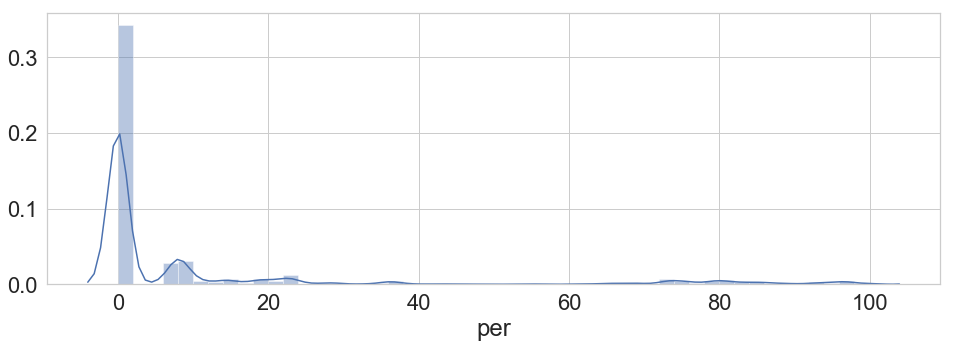

In [13]:
plt.figure(figsize=(16,5))
sns.distplot(nulls['per'], bins=50, hist=True)

## Null handling
1. We have `150` numerical feature with null percentage 50%
2. We have `148` categorical feature with null percentage > 0

1. To handle num value, i use two tech
    - >50% use generalized rank model to fill those value
    - Use MICE for all
    - use SVD on >50% and low feature impotance
2. For Cat feature,
    - make a new catgory(factorize them)
    - Use for encoding based feature(target encoding)

In [22]:
train['Col463'].unique(), np.unique(pd.factorize(train['Col463'])[0]), np.unique(pd.factorize(train['Col463'])[1])

(array([nan,  2.,  1.]), array([-1,  0,  1]), array([1., 2.]))

In [24]:
nulls.to_csv('analysis/null_table.csv', index=None)

In [7]:
count = 0
for col1, col2 in zip(train.columns[2:], test.columns[1:]):
    if col1 == col2:
        count = count+1
        
print("Same columns as thought: ", count,"/",train.shape[1]-2)

Same columns as thought:  2393 / 2393


In [8]:
train['flag'] = 'train'
test['flag']  = 'test'

df = train.iloc[:,2:].append(test.iloc[:,1:])
print("check shapes: ",df.index.unique().shape, train.shape, test.shape, df.shape)
df.reset_index(inplace=True, drop=True)

print()
df.info()

check shapes:  (20442,) (17521, 2396) (20442, 2395) (37963, 2394)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37963 entries, 0 to 37962
Columns: 2394 entries, Col3 to flag
dtypes: float64(835), int64(1545), object(14)
memory usage: 693.4+ MB


In [9]:
test['Col2'] = 99
df1 = train[['Col1','Col2']].append(test[['Col1','Col2']])
print("check shapes: ",df1.index.unique().shape, train.shape, test.shape, df1.shape)
df1.reset_index(inplace=True, drop=True)

df = pd.concat([df,df1], axis=1)
print("final shape: ", df.shape)

check shapes:  (20442,) (17521, 2396) (20442, 2396) (37963, 2)
final shape:  (37963, 2396)


In [10]:
def factorize_cat(table, cat_cols=None):
    print("=== Factorize Done ====")
    for col in cat_cols:
        table[col], _ = pd.factorize(table[col])
    return table

df = factorize_cat(df, cat_cols)

=== Factorize Done ====


In [11]:
def fill_outlier(data, l_per=1, h_per=99, flag='both', filling='bound', cols=None):
    """fill outlier either with nan or bounds values
    Args:
        df  : table
        l_per: lower-percentile
        h_per: higher-percentile
        filling: ['nan','bound'] (by default, it is 'bound')
        flag: string ['lower','upper','both'] (by default, it is 'both')
    return: dataframe
    example:
        fill_outlier(X1, "both", filling="np.nan")
    """
    print("-----outlier handling------")
    df = data.copy()
#     df1 = df.dropna()
    collect_cols = []
    if cols is None:
        cols = list(df.columns)
        # select appropriate columns by dtypes
    cols = df.select_dtypes(exclude='object').columns
    for col in cols:
        try:
            lower_bound = np.percentile(df[col].dropna(), q=l_per)
            upper_bound = np.percentile(df[col].dropna(), q=h_per)
#             print("{} ( {} ) ==> low: {} high: {}".format(col, df[col].dtype, np.round(lower_bound,2), np.round(upper_bound,2)))

            if filling is 'bound':
                lower_bound_fill = lower_bound
                upper_bound_fill = upper_bound
            else:
                lower_bound_fill = np.nan
                upper_bound_fill = np.nan

            if flag == 'upper':
                df[col] = np.where(df[col]>upper_bound, upper_bound_fill, df[col])
            elif flag == 'lower':
                df[col] = np.where(df[col]<lower_bound, lower_bound_fill, df[col])
            else: 
                # when both are selected
                df[col] = np.where(df[col]>upper_bound, upper_bound_fill, df[col])
                df[col] = np.where(df[col]<lower_bound, lower_bound_fill, df[col])
        except:
            collect_cols.append(col)
#     print("null count: ", df.isnull().sum().values)
    if(len(collect_cols) > 0):
        print("There are some columns, which needed extra care: \n\n", collect_cols)
    print("\nDone with outlier handling")
#     new = pd.DataFrame(data=new, columns=df1.columns)
    return df

In [12]:
num_cols.remove('Col1')

In [13]:
# df1 = df.copy()
df = fill_outlier(df, cols=num_cols)

-----outlier handling------

Done with outlier handling


In [14]:
del train, test#, df1
gc.collect()

21

In [92]:
df.head()

,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,Col41,Col42,Col43,Col44,Col45,Col46,Col47,Col48,Col49,Col50,Col51,Col52,Col53,Col54,Col55,Col56,Col57,Col58,Col59,Col60,Col61,Col62,Col63,Col64,Col65,Col66,Col67,Col68,Col69,Col70,Col71,Col72,Col73,Col74,Col75,Col76,Col77,Col78,Col79,Col80,Col81,Col82,Col83,Col84,Col85,Col86,Col87,Col88,Col89,Col90,Col91,Col92,Col93,Col94,Col95,Col96,Col97,Col98,Col99,Col100,Col101,Col102,...,Col2301,Col2302,Col2303,Col2304,Col2305,Col2306,Col2307,Col2308,Col2309,Col2310,Col2311,Col2312,Col2313,Col2314,Col2315,Col2316,Col2317,Col2318,Col2319,Col2320,Col2321,Col2322,Col2323,Col2324,Col2325,Col2326,Col2327,Col2328,Col2329,Col2330,Col2331,Col2332,Col2333,Col2334,Col2335,Col2336,Col2337,Col2338,Col2339,Col2340,Col2341,Col2342,Col2343,Col2344,Col2345,Col2346,Col2347,Col2348,Col2349,Col2350,Col2351,Col2352,Col2353,Col2354,Col2355,Col2356,Col2357,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397,flag,Col1,Col2
0,10867.110000,8648.345000,15766.179090,28904.661670,5273.655000,23461.531670,12855.971630,28715.088760,9114.586439,30430.781520,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,NaN,NaN,1.486524,1.728324,0.993441,1.297050,0.137398,0.115987,0.260428,1.414214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.07,6.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.006045,8.741156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,RIGHGSN,0.0
1,258431.243300,217963.272500,186628.682000,186628.682000,215451.895000,192361.516000,172653.764600,166697.388700,201351.808200,185940.408700,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,NaN,NaN,0.792123,0.934556,0.893203,0.966620,0.753892,0.808295,1.414214,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,116.65,116.65,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957537,12.401945,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,train,RIMHI5ZGP,1.0
2,545828.312246,342923.629144,384947.149886,423458.137146,394996.383652,483985.416954,328249.731194,319751.127468,387776.882052,378115.317746,13.246600,12.932317,13.131402,12.991110,1.145182,2.203874,NaN,NaN,0.422264,0.498347,0.683582,0.735339,0.808115,0.776910,1.414214,NaN,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,-1.0,0.0,-1.0,-1.0,0.0,33.28,33.28,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.482401,0.647102,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,0.0,1.0,2.

1.0    15760
0.0     1761
Name: Col2, dtype: int64

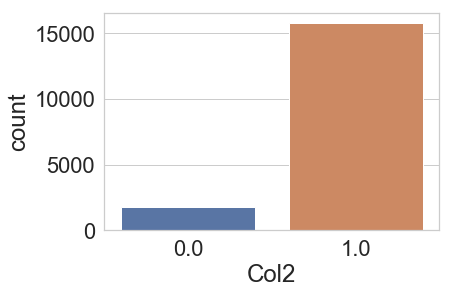

In [15]:
gc.collect()
sns.countplot(df[df['flag'] == 'train']['Col2'])
df[df['flag'] == 'train']['Col2'].value_counts()

In [16]:
num_nulls_cols = nulls[(nulls['type'] == 'num') & (nulls['per'] > 40)].col.values
len(num_nulls_cols)

150

In [18]:
imp_automl = pd.read_csv('importance_with_drop_518.csv')
imp_automl.sort_values(by="percentage", ascending=False).head(50)

,columns,rel_imp,sca_imp,percentage
487,Col152,2318.377747,4.000000,0.306188
421,Col141,1879.989151,3.353976,0.261753
495,Col153,1587.270340,2.831693,0.224225
525,Col158,1291.895134,2.066135,0.148302
520,Col157,1263.966827,1.977488,0.139032
1621,Col770,1178.921722,1.824695,0.127082
427,Col142,1116.665253,1.738608,0.121397
1719,Col859,1080.032974,1.682972,0.117827
1675,Col819,999.150124,1.561373,0.110588
455,Col147,940.509521,1.476294,0.104765


## weird thing, ALL NUM col with have some importance in ML Model(Auto ML)

In [20]:
no_imp = imp_automl[imp_automl.percentage <= 1e-5]['columns'].values
len(set(no_imp).intersection(set(num_nulls_cols))), len(set(no_imp).intersection(set(cat_cols))), len(no_imp)
# no_imp

(0, 319, 319)

In [21]:
len(set(no_imp).intersection(set(cat_cols))), len(no_imp)


(319, 319)

In [22]:
df.drop(no_imp, axis=1, inplace=True)

## Let's check the feature importance of GBM, trained yesterday(23-sep)

In [31]:
!ls predictions/

imp_cat1.csv  imp_xgb1.csv  oof_cat2.npy  oof_xgb2.npy	  predi_lgb1.npy
imp_cat2.csv  imp_xgb2.csv  oof_lgb1.npy  predi_cat1.npy  predi_xgb1.npy
imp_lgb1.csv  oof_cat1.npy  oof_xgb1.npy  predi_cat2.npy  predi_xgb2.npy


In [37]:
imp_cat1 = pd.read_csv('predictions/imp_cat1.csv').sort_values(by='feature')
imp_cat2 = pd.read_csv('predictions/imp_cat2.csv').sort_values(by='feature')
imp_xgb1 = pd.read_csv('predictions/imp_xgb1.csv').sort_values(by='feature')
imp_xgb2 = pd.read_csv('predictions/imp_xgb2.csv').sort_values(by='feature')
imp_lgb1 = pd.read_csv('predictions/imp_lgb1.csv').sort_values(by='feature')
print(imp_cat1.shape, imp_cat2.shape, imp_xgb1.shape, imp_xgb2.shape, imp_lgb1.shape)

imp_all = pd.DataFrame(data = pd.concat([imp_cat1, imp_cat2['imp'], imp_xgb1['imp'], imp_xgb2['imp'], imp_lgb1['imp']], axis=1))
imp_all.columns = ['feature','cat1','cat2','xgb1','xgb2','lgb1']
imp_all

(2074, 2) (2074, 2) (1114, 2) (1534, 2) (2074, 2)


,feature,cat1,cat2,xgb1,xgb2,lgb1
0,Col2168,0.000000,0.000000,1.0,1.0,0.00
1,Col1790,0.000000,0.000000,1.0,1.0,0.00
2,Col333,0.000000,0.000000,1.0,1.0,0.00
3,Col1794,0.000000,0.000000,1.0,1.0,0.00
4,Col1796,0.000000,0.000000,1.0,1.0,0.00
5,Col1797,0.000000,0.000000,1.0,1.0,0.00
6,Col1798,0.000000,0.000000,1.0,1.0,0.00
7,Col1799,0.000000,0.000000,1.0,1.0,0.00
8,Col329,0.000000,0.000000,1.0,1.0,0.00
9,Col328,0.000000,0.000000,1.0,1.0,0.00


In [35]:
imp_all

,feature,imp,0
2041,Col10,0.509955,NaN
647,Col100,0.000000,NaN
1433,Col1000,0.029347,NaN
1215,Col1001,0.016589,NaN
1395,Col1002,0.026913,NaN
1651,Col1004,0.051593,NaN
651,Col1006,0.000000,NaN
652,Col1007,0.000000,NaN
653,Col101,0.000000,NaN
654,Col1010,0.000000,NaN


In [38]:
df.shape

(37963, 2077)

There is some problem in these two feature, correct them

In [40]:
df['Col754']  = df['Col754'].replace('-',0).astype('float')
df['Col843']  = df['Col843'].replace('-',0).astype('float')


## There are some intersting feature, with good importance as well
    - create qunatile bins
    - use them for feature-interaction

In [150]:
dangers = []
for col in df.columns:
    if col == 'Col1':
        continue
    amount = len(df[col].unique())
    if amount > 0.9*df.shape[0]:
        dangers.append([col, amount, imp[imp['columns'] == col]['percentage'].values[0]])
        
dangers = pd.DataFrame(dangers, columns=['column','uni_count', 'per'])
dangers = dangers.sort_values(by='per', ascending=False)
dangers

,column,uni_count,per
10,Col13,34594,0.005554
22,Col166,34583,0.005248
26,Col178,34315,0.003019
20,Col162,34674,0.002380
11,Col14,34596,0.001902
25,Col176,34254,0.001594
13,Col16,34647,0.001264
19,Col26,34386,0.000850
21,Col164,34670,0.000788
8,Col11,35077,0.000683


17521    RIGD58ZWD
17522    RIH660YDS
17523    RIH660Q96
17524    RIYDO15W1
17525    RIYBGC1ZD
17526    RIYBQ5SWR
17527    RIYBQ5SD5
17528     TI5HU5XY
17529     TIYHGOSE
17530     T90K61QJ
17531     T7VUCSYG
17532     T10BV81R
17533     T1EWVOZZ
17534     TDYO6BYZ
17535     TDY6VY5E
17536     TYWOUOSR
17537     TYGRLBSY
17538     TYE6VOKZ
17539     TSW65YKE
17540     TS5HVY1Z
17541      TSMKICK
17542     T25ROOSG
17543     99LRCY1W
17544     99YKLSZ5
17545     970WOYQY
17546     97MKU1NG
17547     9LWB6C1J
17548     9L5BQC15
17549     9DMD5CKW
17550     9Y0IVBQZ
17551     9YM6QCYG
17552     9S5HOY59
17553     9SH6IS1Z
17554     9SYK65SD
17555     92GB5SN5
17556     92GR5O4E
17557     92HHL54D
17558     92YBQMNW
17559     92EUCSSZ
17560     9NLDCC4D
17561     9N5ICBZ5
17562     9NMWI049
17563     9NHDCSYD
17564     AILK58QW
17565     AIWWOYXE
17566     AIWRGO1Z
17567     AIGBVONY
17568     AI5R5BZY
17569     AI5HQ04Y
17570     AIMILB1J
17571     AIHROO1E
17572     AIEH5BN5
17573     A9

In [41]:
train = df[df['flag'] == 'train']
test  = df[df['flag'] == 'test']

tr_ids = train['Col1']
ts_ids = test['Col1']

target = train['Col2']
train.drop(['flag','Col1','Col2'], axis=1, inplace=True)
test.drop(['flag','Col1','Col2'], axis=1, inplace=True)

print(train.shape, test.shape)

(17521, 2074) (20442, 2074)


In [156]:
# from sklearn.model_selection import train_test_split


# X_tr, X_val, y_tr, y_val = train_test_split(train, target,
#                                             test_size=0.3, 
#                                             stratify=target, 
#                                             random_state=123456)
# X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((12264, 2074), (5257, 2074), (12264,), (5257,))

In [193]:
del X_tr, X_val, y_tr, y_val
gc.collect()

1971

In [224]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.09
    }
    
    n_splits = 4
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb, predictions


In [186]:
# def xg_f1(y,t):
# #     t = t.get_label()
#     y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
#     return f1_score(t,y_bin, average='weighted')
# #     return 'f1',f1_score(t,y_bin)

In [189]:
# reduce_mem_usage_wo_print(df)

In [190]:
del df
gc.collect()

1075

In [191]:
# reduce_mem_usage_wo_print(train)
# reduce_mem_usage_wo_print(test)

Memory 277.37 MB ==> 

KeyboardInterrupt: 

In [225]:
clf_xgb1, imp_xgb1, oof_xgb1, predi_xgb1 = run_cv_xgb(train, target, test, depth=4)

np.save('predictions/oof_xgb1.npy', oof_xgb1)
np.save('predictions/predi_xgb1.npy', predi_xgb1)
imp_xgb1.to_csv('predictions/imp_xgb1.csv', index=None)

(13140,) (4381,)
Fold 0
[0]	valid-auc:0.663806
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[142]	valid-auc:0.744615

  auc =  0.7446153757611336
  f1 =  0.8618569876860083
(13141,) (4380,)
Fold 1
[0]	valid-auc:0.674078
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[92]	valid-auc:0.748897

  auc =  0.7488965159206276
  f1 =  0.8607175578576941
(13141,) (4380,)
Fold 2
[0]	valid-auc:0.666223
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[100]	valid-auc:0.737731

  auc =  0.7377307337332719
  f1 =  0.8578209598569212
(13141,) (4380,)
Fold 3
[0]	valid-auc:0.649481
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[51]	valid-auc:0.705534

  auc =  0.7055344370096909
  f1 =  0.8560135723274875


In [226]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

Waking up


'Mon Sep 23 20:26:25 2019'

'Mon Sep 23 20:21:58 2019'

In [227]:
clf_xgb2, imp_xgb2, oof_xgb2, predi_xgb2 = run_cv_xgb(train, target, test, depth=6)

np.save('predictions/oof_xgb2.npy', oof_xgb2)
np.save('predictions/predi_xgb2.npy', predi_xgb2)
imp_xgb2.to_csv('predictions/imp_xgb2.csv', index=None)

(13140,) (4381,)
Fold 0
[0]	valid-auc:0.673723
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[105]	valid-auc:0.742429

  auc =  0.7424286635127824
  f1 =  0.8611355757952344
(13141,) (4380,)
Fold 1
[0]	valid-auc:0.671854
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[35]	valid-auc:0.737424

  auc =  0.7374235694508536
  f1 =  0.8563799169357607
(13141,) (4380,)
Fold 2
[0]	valid-auc:0.663871
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[86]	valid-auc:0.739555

  auc =  0.7395546838947854
  f1 =  0.8591114670200914
(13141,) (4380,)
Fold 3
[0]	valid-auc:0.645717
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[126]	valid-auc:0.717172

  auc =  0.7171720696815874
  f1 =  0.8593706723240285


In [228]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

Waking up


'Mon Sep 23 20:29:18 2019'

In [42]:
pred_xgb1 = np.load('predictions/predi_xgb1.npy')
pred_xgb1.shape, pred_xgb1

((20442, 4), array([[0.93158913, 0.890715  , 0.90352082, 0.87550819],
        [0.80352068, 0.78007185, 0.7875604 , 0.67747438],
        [0.97807294, 0.96387631, 0.96853906, 0.91215861],
        ...,
        [0.95114237, 0.94754219, 0.94572711, 0.90708846],
        [0.97419351, 0.96225452, 0.95545596, 0.92613184],
        [0.77279711, 0.64309454, 0.64979541, 0.59738052]]))

In [51]:
pred_xgb1 = np.load('predictions/predi_xgb1.npy')
oof_xgb1 = np.load('predictions/oof_xgb1.npy')

pred_xgb1 = pd.DataFrame(data=pred_xgb1).apply(lambda x: np.mean(x), axis=1)
oof_xgb1  = pd.DataFrame(data=oof_xgb1).apply(lambda x: np.mean(x), axis=1)


In [72]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_xgb1]
print(cr(target, ybins))

              precision    recall  f1-score   support

         0.0       0.54      0.04      0.07      1761
         1.0       0.90      1.00      0.95     15760

   micro avg       0.90      0.90      0.90     17521
   macro avg       0.72      0.52      0.51     17521
weighted avg       0.87      0.90      0.86     17521



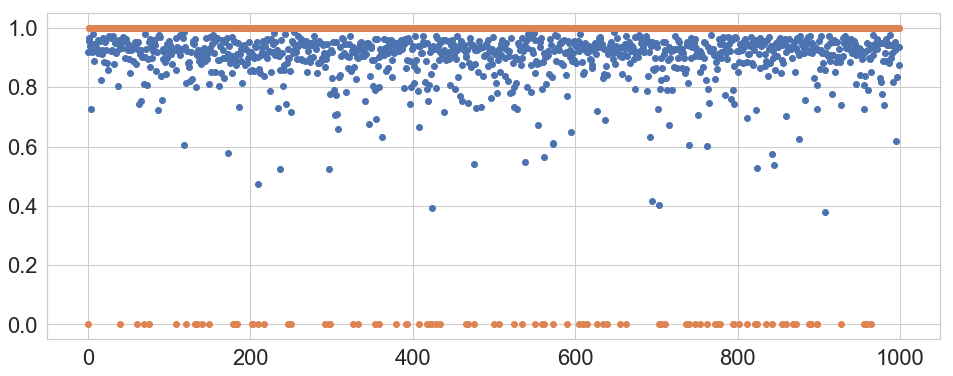

In [69]:
lens = np.arange(len(target))
plt.figure(figsize=(16,6))
plt.plot(lens[:1000], oof_xgb1.values[:1000], 'o')
plt.plot(lens[:1000], target.values[:1000], 'o')

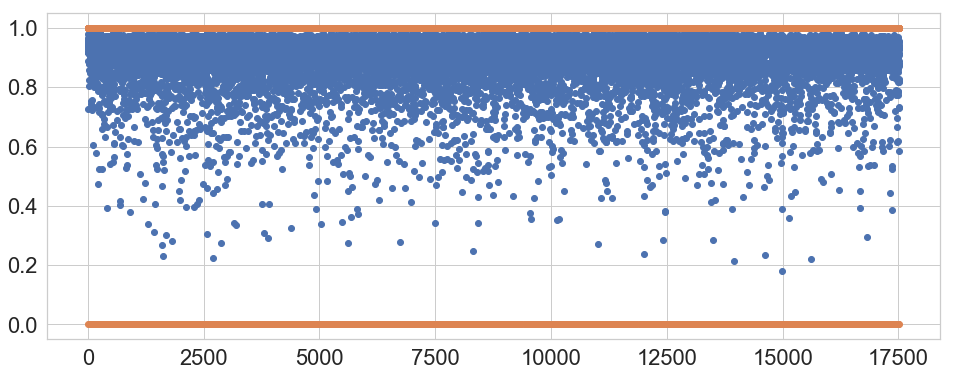

In [68]:
lens = range(len(target))
plt.figure(figsize=(16,6))
plt.plot(lens, oof_xgb1, 'o')
plt.plot(lens, target, 'o')

In [76]:
ybins = [1.0 if y > 0.5 else 0 for y in pred_xgb1]

sub_xgb1 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_xgb1.columns = ['Col1','Col2']
sub_xgb1

,Col1,Col2
0,RIGD58ZWD,1.0
1,RIH660YDS,1.0
2,RIH660Q96,1.0
3,RIYDO15W1,1.0
4,RIYBGC1ZD,1.0
5,RIYBQ5SWR,1.0
6,RIYBQ5SD5,1.0
7,TI5HU5XY,1.0
8,TIYHGOSE,1.0
9,T90K61QJ,1.0


In [80]:
sub_xgb1.to_csv('predictions/sub_xgb1.csv', index=None)
sub_xgb1['Col2'].value_counts(), sub_xgb1['Col1'].unique().shape

(1.0    20286
 0.0      156
 Name: Col2, dtype: int64, (20442,))

In [ ]:
# clf_xgb2, imp_xgb2, oof_xgb2, predi_xgb2 = run_cv_xgb(train, target, test, depth=6)

# np.save('predictions/oof_xgb2.npy', oof_xgb2)
# np.save('predictions/predi_xgb2.npy', predi_xgb2)
# imp_xgb2.to_csv('predictions/imp_xgb2.csv', index=None)

In [ ]:
# import time, datetime
# time.sleep(10)
# print("Waking up")

# time.ctime()

In [179]:
# test['Col754'].unique()
# np.array(test['Col754'].unique(), dtype='float')
# train[['Col754','Col843']]

In [ ]:
# Use Case A: Submissions are evaluated based on the F1_score technique. 
# It uses the predicted probability and the observed target with the weighted average

In [ ]:
def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, lgb_imp
    


    
def run_cv_lgb(train_df, target, test_df, leaves=None):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'auc',
        'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'binary',
        'verbosity'              : 1,
        'lambda_l1'              : 0.01,
        'lambda_l2'              : 0.1
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 4
    num_round = 10
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
#         X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#         X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)

        num_round = 10000
        oof, test_pred, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, param, 
                                                       test_df, num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
    print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_lgb, predictions




def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    test_pred  = clf.predict_proba(X_test[features])[:,1]

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.09,
        'thread_count'          : 4
    }


    ##########################
    n_splits = 4
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions






In [ ]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train, target, test, depth=4)
np.save('predictions/oof_cat1.npy', oof_cat1)
np.save('predictions/predi_cat1.npy', predi_cat1)
imp_cat1.to_csv('predictions/imp_cat1.csv', index=None)

(13140,) (4381,)
Fold 0
0:	test: 0.5597472	test1: 0.5706073	best: 0.5706073 (0)	total: 269ms	remaining: 44m 50s
200:	test: 0.7894145	test1: 0.7340015	best: 0.7342611 (196)	total: 31.6s	remaining: 25m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7384045835
bestIteration = 345

Shrink model to first 346 iterations.
  auc =  0.7384045834916031
  f1 =  0.8570395274236802
(13141,) (4380,)
Fold 1
0:	test: 0.5580506	test1: 0.5347220	best: 0.5347220 (0)	total: 163ms	remaining: 27m 10s
200:	test: 0.7841664	test1: 0.7367469	best: 0.7376474 (185)	total: 28.5s	remaining: 23m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7383067028
bestIteration = 227

Shrink model to first 228 iterations.
  auc =  0.7383067028149515
  f1 =  0.8564716872558724
(13141,) (4380,)
Fold 2
0:	test: 0.5523789	test1: 0.5519961	best: 0.5519961 (0)	total: 155ms	remaining: 25m 45s
200:	test: 0.7893940	test1: 0.7330313	best: 0.7336744 (190)	total: 28.8s	remaining: 23m 25s
St

In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

Waking up


'Mon Sep 23 20:33:18 2019'

In [ ]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train, target, test, depth=6)
np.save('predictions/oof_cat2.npy', oof_cat2)
np.save('predictions/predi_cat2.npy', predi_cat2)
imp_cat2.to_csv('predictions/imp_cat2.csv', index=None)

(13140,) (4381,)
Fold 0
0:	test: 0.5705275	test1: 0.5667904	best: 0.5667904 (0)	total: 6.95s	remaining: 19h 18m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.73446971
bestIteration = 143

Shrink model to first 144 iterations.
  auc =  0.7344697100498405
  f1 =  0.8522323876963566
(13141,) (4380,)
Fold 1
0:	test: 0.5625085	test1: 0.5121980	best: 0.5121980 (0)	total: 421ms	remaining: 1h 10m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7243478888
bestIteration = 129

Shrink model to first 130 iterations.
  auc =  0.7243478887863406
  f1 =  0.8531715169328691
(13141,) (4380,)
Fold 2
0:	test: 0.5556325	test1: 0.5487794	best: 0.5487794 (0)	total: 478ms	remaining: 1h 19m 34s
200:	test: 0.8290627	test1: 0.7355941	best: 0.7363541 (168)	total: 1m 14s	remaining: 1h 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7363541186
bestIteration = 168

Shrink model to first 169 iterations.
  auc =  0.736354118597139
  f1 =  0.853

In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

Waking up


'Mon Sep 23 20:39:52 2019'

In [ ]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train, target, test, leaves=100)

np.save('predictions/oof_lgb1.npy', oof_lgb1)
np.save('predictions/predi_lgb1.npy', predi_lgb1)
imp_lgb1.to_csv('predictions/imp_lgb1.csv', index=None)

using leaves:  100
(13140,) (4381,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[37]	training's auc: 0.789725	valid_1's auc: 0.731281


In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

In [ ]:

clf_lgb2, imp_lgb2, oof_lgb2, predi_lgb2 = run_cv_lgb(train, target, test, leaves=200)

np.save('predictions/oof_lgb2.npy', oof_lgb2)
np.save('predictions/predi_lgb2.npy', predi_lgb2)
imp_lgb2.to_csv('predictions/imp_lgb2.csv', index=None)

In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

In [ ]:
clf_cat3, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(train, target, test, depth=8)
np.save('predictions/oof_cat3.npy', oof_cat3)
np.save('predictions/predi_cat3.npy', predi_cat3)
imp_cat3.to_csv('predictions/imp_cat3.csv', index=None)


In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

In [ ]:
clf_xgb3, imp_xgb3, oof_xgb3, predi_xgb3 = run_cv_xgb(train, target, test, depth=8)

np.save('predictions/oof_xgb3.npy', oof_xgb3)
np.save('predictions/predi_xgb3.npy', predi_xgb3)
imp_xgb3.to_csv('predictions/imp_xgb3.csv', index=None)

In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

In [ ]:

clf_lgb3, imp_lgb3, oof_lgb3, predi_lgb3 = run_cv_lgb(train, target, test, leaves=300)

np.save('predictions/oof_lgb3.npy', oof_lgb3)
np.save('predictions/predi_lgb3.npy', predi_lgb3)
imp_lgb3.to_csv('predictions/imp_lgb3.csv', index=None)

In [ ]:
import time, datetime
time.sleep(10)
print("Waking up")

time.ctime()

In [216]:
oof_lgb1

array([0.5910583 , 0.59990116, 0.6807872 , ..., 0.77918239, 0.57296914,
       0.66431834])

In [219]:
np.save('predictions/oof_lgb1.npy', oof_lgb1)
np.save('predictions/predi_lgb1.npy', predi_lgb1)
imp_lgb1.to_csv('predictions/imp_lgb1.csv', index=None)
# !mkdir predictions

In [14]:
nulls[(nulls['per'] > 50) & (nulls['type'] == 'num')].shape

(150, 3)

In [22]:
nulls[(nulls['per'] > 0) & (nulls['type'] == 'cat')].shape

(148, 3)

In [30]:
np.unique(pd.factorize(train['Col253'])[0])

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103])

In [31]:
np.unique(pd.factorize(train['Col253'])[1])

array([0.        , 0.20327891, 0.36514837, 0.4       , 0.44095826,
       0.48989797, 0.48989863, 0.55075739, 0.55777335, 0.55901699,
       0.57734998, 0.58554018, 0.58794509, 0.60380777, 0.61237274,
       0.63245553, 0.64523371, 0.66666667, 0.67936617, 0.68312944,
       0.68313027, 0.68835249, 0.69721669, 0.70710678, 0.71260964,
       0.72156826, 0.73981444, 0.76594183, 0.77459677, 0.77459698,
       0.78726868, 0.80288756, 0.80507679, 0.81649658, 0.81649663,
       0.81649679, 0.84273597, 0.85714286, 0.88917557, 0.90332781,
       0.90829502, 0.91287093, 0.93541318, 0.9354144 , 0.97499639,
       1.        , 1.00203857, 1.04582503, 1.04969126, 1.0583005 ,
       1.08945931, 1.09544511, 1.15469996, 1.15470039, 1.15470054,
       1.17803018, 1.17983117, 1.22474456, 1.22474487, 1.24721884,
       1.24721975, 1.27656971, 1.29785128, 1.30690054, 1.33166516,
       1.36930639, 1.37689203, 1.40285497, 1.41421356, 1.41748344,
       1.47709783, 1.48823533, 1.49071198, 1.54919281, 1.54919

519


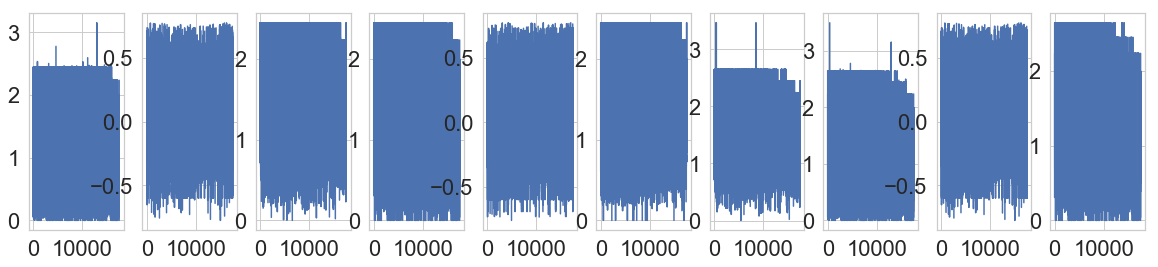

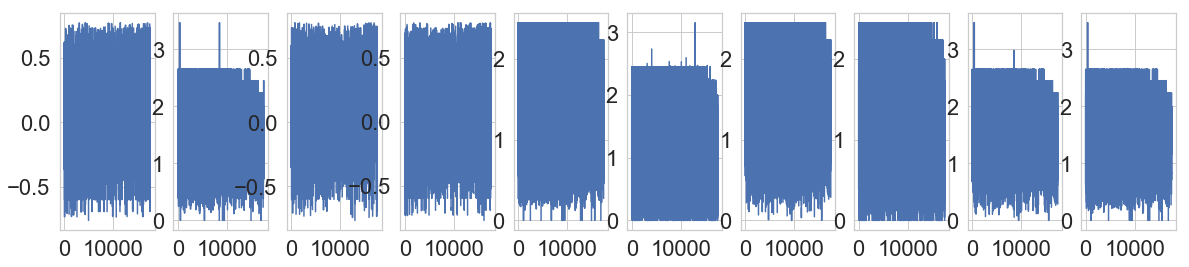

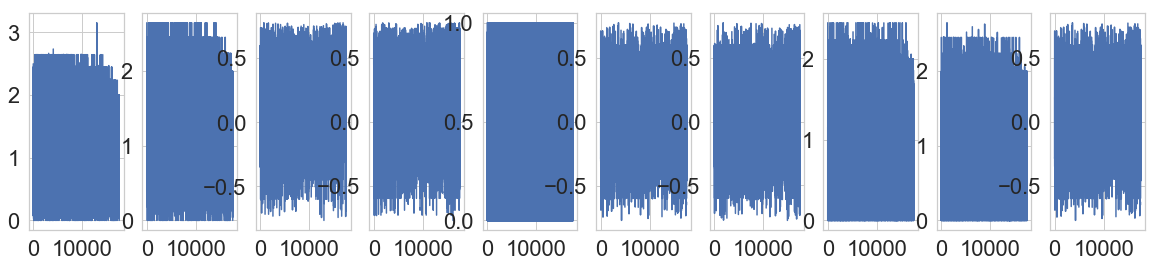

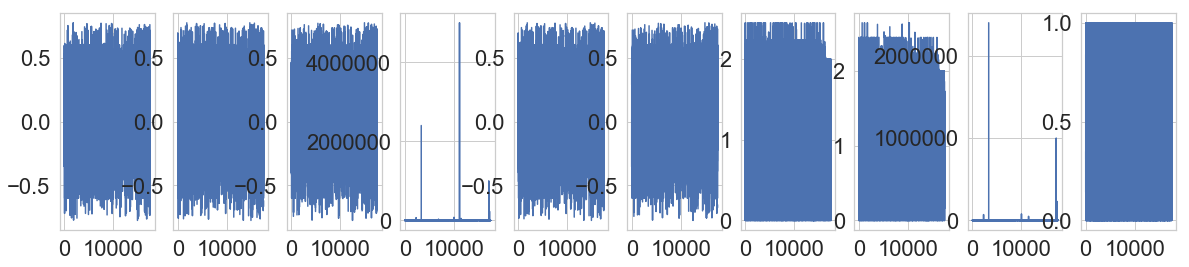

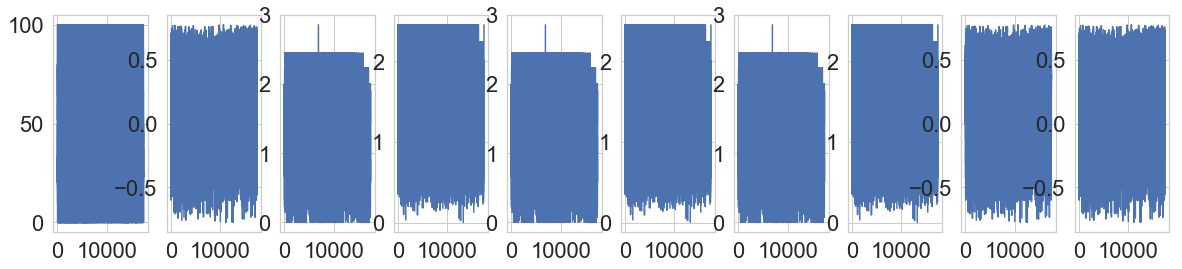

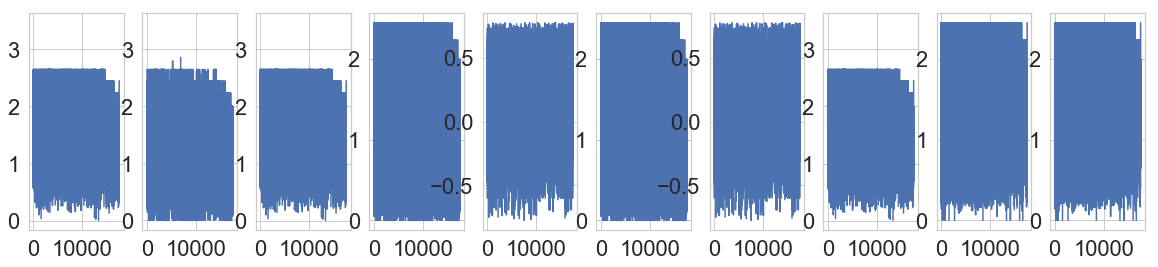

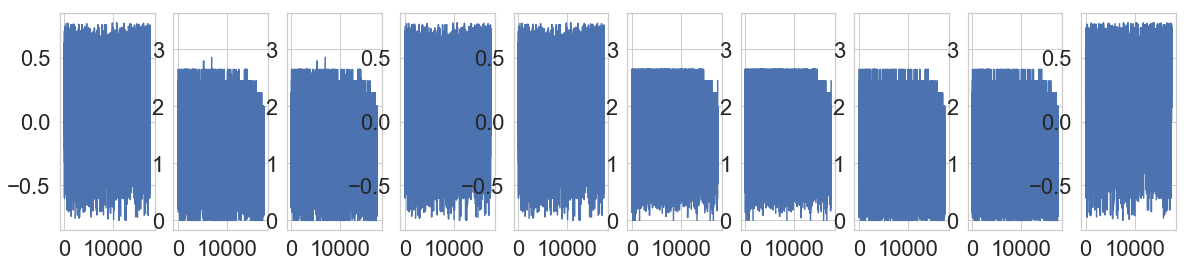

In [ ]:
# all_cols = nulls[(nulls['per'] <= 50) & (nulls['type'] == 'num')].col.values
# print(len(all_cols))

# # fig, ax = plt.figure()
# for i, col in enumerate(all_cols):
#     if i == 100:
#         break
#     if i%10 == 0:
#         fig, ax = plt.subplots(1,10,figsize=(30,4))
#         axes = ax.flatten()
# #     plt.figure()
#     axes[i%10].plot(train[col])

In [ ]:
def fill_outlier(data, flag, filling=None, cols=None):
    """fill outlier either with nan or bounds values
    Args:
        df  : feature
        filling: ['nan','bound'] (by default, it is 'bound')
        flag: string ['lower','upper','both']
    return: dataframe
    example:
        fill_outlier(X1, "both", filling="np.nan")
    """
    df = data.copy()
    df1 = df.dropna()
    if cols is None:
        cols = list(df.columns)
        # select appropriate columns by dtypes
    cols = df.select_dtypes(exclude='object').columns
    for col in cols:
        lower_bound = np.percentile(df1[col], q=1)
        upper_bound = np.percentile(df1[col], q=99)
        print(col, "(", df[col].dtype, ") ==>","low: ", np.round(lower_bound,2), 
              " high: ", np.round(upper_bound,2))
        
        if filling is None or filling == "bound":
            lower_bound_fill = lower_bound
            upper_bound_fill = upper_bound
        else:
            lower_bound_fill = np.nan
            upper_bound_fill = np.nan
        if flag == 'upper':
            df[col] = np.where(df[col]>upper_bound, upper_bound_fill, df[col])
        elif flag == 'lower':
            df[col] = np.where(df[col]<lower_bound, lower_bound_fill, df[col])
        else: 
            # when both are selected
            df[col] = np.where(df[col]>upper_bound, upper_bound_fill, df[col])
            df[col] = np.where(df[col]<lower_bound, lower_bound_fill, df[col])
    print("null count: ", df.isnull().sum().values)
#     new = pd.DataFrame(data=new, columns=df1.columns)
    return df

In [ ]:
# collect = []
# for col in tf.columns:
#     collect.append(tf[col].unique().shape[0])

# plt.figure(figsize=(20,8))
# plt.plot(range(len(collect)), collect, '-o')

In [7]:
np.unique(ids).shape, ids.shape

((17521,), (17521,))

In [21]:
# np.random.randint(len(samples), shape=len(samples))

df.loc[valid].shape

(5000, 2393)

In [4]:
target.value_counts()

NameError: name 'target' is not defined

In [23]:
df['target'] = target
df.shape

(17521, 2394)

In [36]:
df.iloc[:,:100].apply(lambda x: pd.Series.value_counts(x).shape[0])

Col3      16308
Col4      16327
Col5      16325
Col6      16325
Col7      16307
Col8      16298
Col9      16327
Col10     16327
Col11     16318
Col12     16319
Col13      1566
Col14      1925
Col15      1887
Col16      1460
Col17      1251
Col18      5901
Col19      2258
Col20      2540
Col21      3671
Col22      4035
Col23      3494
Col24      4054
Col25      5796
Col26      6618
Col27      4415
Col28      1889
Col29         8
Col30         7
Col31         8
Col32        32
          ...  
Col73         8
Col74         7
Col75         7
Col76         6
Col77         6
Col78         6
Col79         6
Col80         6
Col81         6
Col82         6
Col83         6
Col84         3
Col85         3
Col86         3
Col87         3
Col88         3
Col89         3
Col90         3
Col91         3
Col92      8702
Col93      9564
Col94         9
Col95        11
Col96         9
Col97        11
Col98        10
Col99        11
Col100        8
Col101       11
Col102        8
Length: 100, dtype: int6

In [52]:
17521*0.05

876.0500000000001

In [104]:
# cat_cols = []
# mid_cols = []
# num_cols = []

# for col in train.columns:
#     uni_values = train[col].value_counts().shape[0]
#     if uni_values <= 50:
#         cat_cols.append(col)
#     elif uni_values < 500:
#         mid_cols.append(col)
#     else:
#         num_cols.append(col)
        
        
def grouping_cols(df, cat_percentage = 0.05):
    cc, nc = [], []
    max_ = 0
    amount = df.shape[0]*cat_percentage
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("max unique values: ", max_)
    print("total cat cols: {}, total num cols: {}".format(len(cc), len(nc)))
    return cc, nc

cat_cols, num_cols = grouping_cols(train)


max unique values:  17521
total cat cols: 1804, total num cols: 591


In [58]:
train.shape

(17521, 2395)

In [110]:
import random, math

true_cat = []
true_num = []
for col in num_cols+cat_cols:
#     print(col)
    num = False
    if(train[col].dtype == 'object'):
        true_cat.append(col)
        continue
    for i in range(10):
        sample = np.random.choice(train[col].unique())
        if math.isnan(sample): continue
        if int(sample) != sample:
            num = True
    if num is True:
        true_num.append(col)
    else:
        true_cat.append(col)

print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))


total cat cols: 1641, total num cols: 754


In [119]:
train[true_cat].head()
# train['Col1'].dtype == 'object'

,Col1,Col2,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,...,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1,1,1,1,1,1,1,0,6,...,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,0,1,1,3,4,4,0,4,5,...,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,0,3,3,4,12,4,0,2,4,...,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,0,2,2,2,24,1,0,1,4,...,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,0,4,3,4,68,8,0,2,4,...,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [123]:
train[['Col2395', 'Col2396']].corr()#.unique()

,Col2395,Col2396
Col2395,1.000000,0.998623
Col2396,0.998623,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cf45da400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cf45da400>)

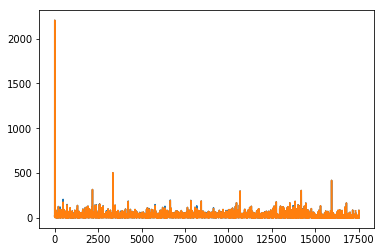

In [125]:
train['Col2395'].plot(), train['Col2396'].plot()

In [127]:
corr = train[true_num[:100]].corr()

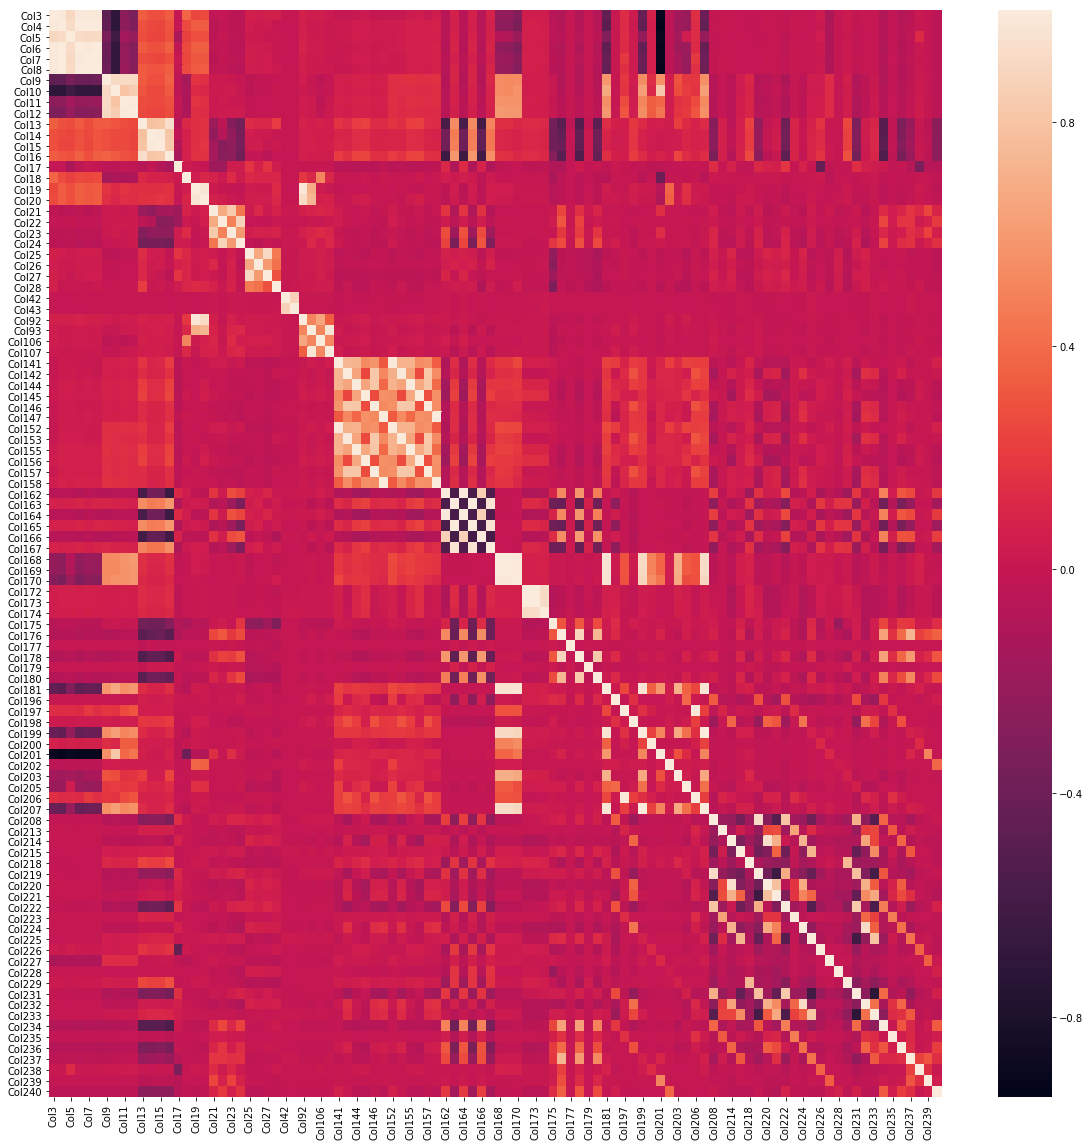

In [130]:
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(corr)

In [131]:
gc.collect()

1277

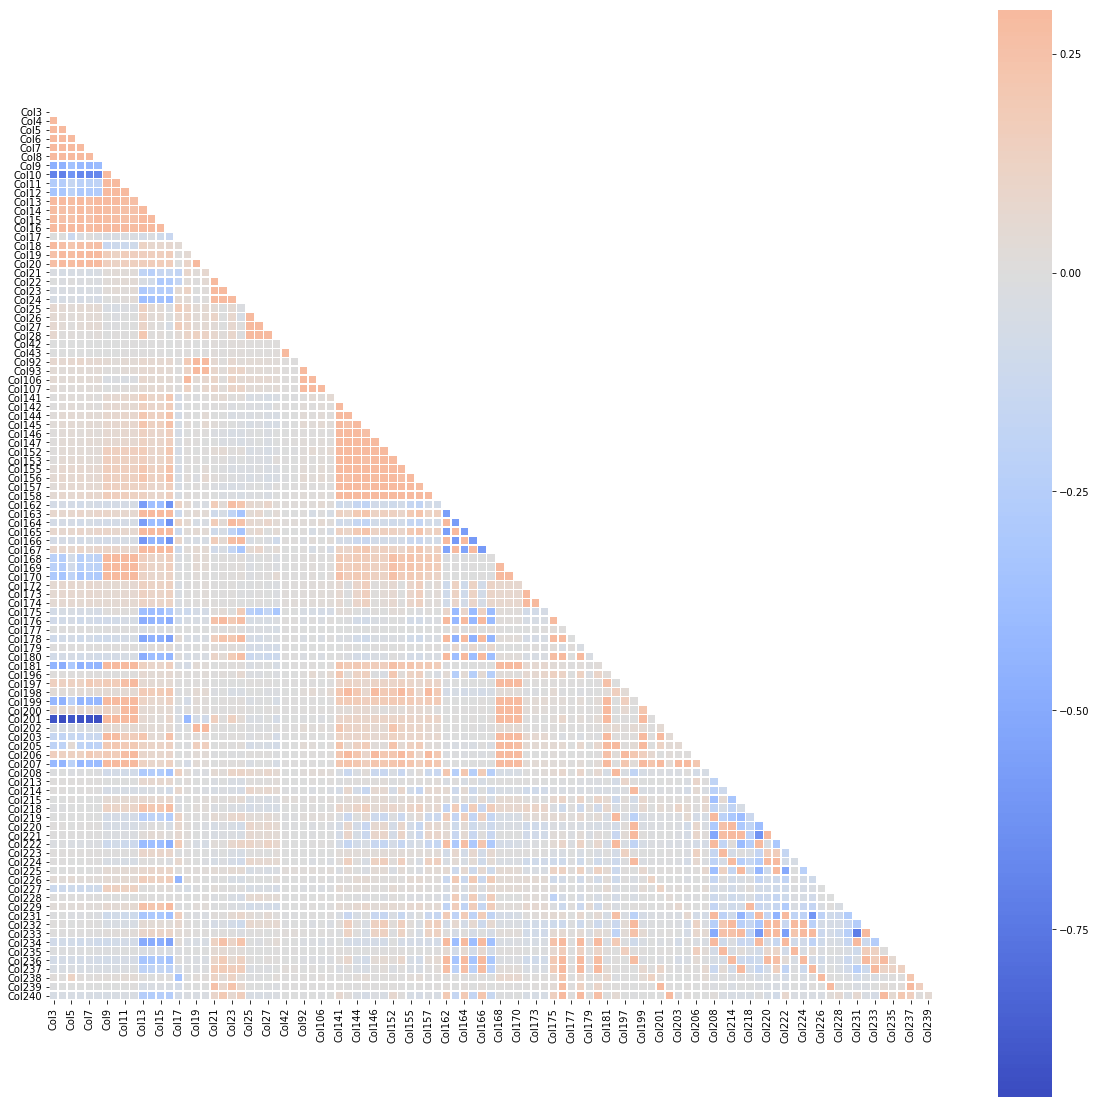

In [138]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=False)


# vmin=-1,
#             cmap='coolwarm',
#             annot=True

In [157]:
pd.DataFrame(corr['Col141']).sort_values(by='Col141')

,Col141
Col162,-0.098146
Col164,-0.093905
Col166,-0.067413
Col222,-0.065472
Col220,-0.065243
Col221,-0.064425
Col214,-0.061793
Col17,-0.058442
Col27,-0.048846
Col25,-0.042332


In [169]:
# null_values = pd.DataFrame()
null_values = []
for col in true_cat:
    amount = train[col].isnull().sum()
    null_values.append([col, 'cat', amount])

for col in true_num:
    amount = train[col].isnull().sum()
    null_values.append([col, 'num', amount])



In [170]:
null_values = pd.DataFrame(null_values, columns=['col','type', 'per'])
null_values['per'] = null_values['per']*100/train.shape[0]
null_values.sort_values(by='per', ascending=False).head(100)

,col,type,per
127,Col485,cat,99.960048
126,Col463,cat,99.960048
119,Col266,cat,99.960048
134,Col813,cat,99.960048
132,Col724,cat,99.960048
120,Col288,cat,99.960048
115,Col171,cat,99.372182
178,Col930,cat,97.751270
13,Col40,cat,97.288968
11,Col38,cat,97.226186


In [193]:
null_values[(null_values['per'] > 80) & (null_values['type'] == 'cat')].col.

10      Col37
11      Col38
12      Col39
13      Col40
14      Col41
115    Col171
118    Col185
119    Col266
120    Col288
121    Col352
122    Col373
125    Col382
126    Col463
127    Col485
128    Col549
129    Col570
132    Col724
133    Col747
134    Col813
135    Col836
178    Col930
Name: col, dtype: object

In [194]:
del train
gc.collect()

84

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = data.columns[columns]
data = data[selected_columns]

In [ ]:
selected_columns = selected_columns[1:].values


import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns


SL = 0.05
data_modeled, selected_columns = backwardElimination(
    data.iloc[:,1:].values, 
    data.iloc[:,0].values, 
    SL, 
    selected_columns)

In [23]:
# for col in danger_cols50:
#     print(train[col].dtype)
train[danger_cols50].head()

,Col19,Col20,Col28,Col37,Col38,Col39,Col40,Col41,Col97,Col99,...,Col849,Col852,Col853,Col856,Col857,Col858,Col859,Col920,Col925,Col930
0,NaN,NaN,1.414214,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.4972,2.4972,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.288675,NaN,NaN,0.288675,NaN,NaN,NaN,10.6602,10.6602,1.0
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,...,-0.350470,NaN,NaN,-0.021901,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,-0.174136,NaN,NaN,-0.246718,NaN,-0.069164,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,0.0,0.0,...,NaN,0.190703,NaN,NaN,NaN,NaN,0.270319,3.0570,3.0570,4.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cf20b7940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cf20b7940>)

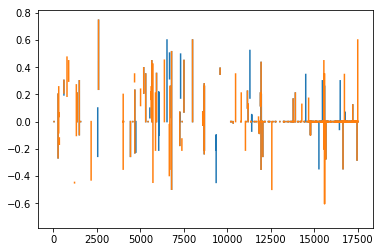

In [35]:
train['Col853'].plot(),train['Col857'].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cf21ae860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cf21ae860>)

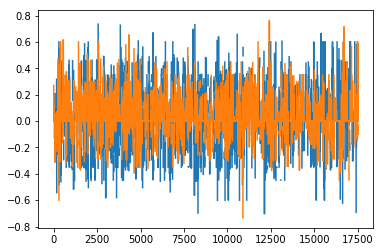

In [36]:
train['Col858'].plot(),train['Col859'].plot()

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


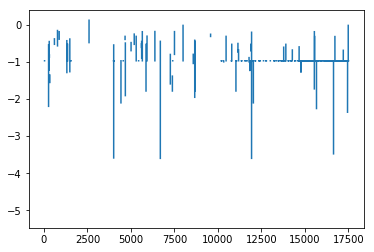

In [48]:
plt.plot(np.log(1+train['Col857'].min()+train['Col857']))

In [ ]:
danger_cat_cols = []
danger_num_cols = []

for col in cat_cols:
    amount = df[col].isnull().sum()
    if amount > 10000:
        danger_cat_cols.append(col)

for col in num_cols:
    amount = df[col].isnull().sum()
    if amount > 10000:
        danger_num_cols.append(col)

len(danger_cat_cols), len(danger_num_cols)

In [5]:
cat_cols = []
mid_cols = []
num_cols = []

for col in train.columns:
    uni_values = train[col].value_counts().shape[0]
    if uni_values <= 50:
        cat_cols.append(col)
    elif uni_values < 500:
        mid_cols.append(col)
    else:
        num_cols.append(col)

In [6]:
len(cat_cols), len(mid_cols), len(num_cols)

(1610, 134, 651)

In [8]:
train[mid_cols]

,Col37,Col40,Col143,Col148,Col154,Col159,Col186,Col187,Col189,Col192,...,Col922,Col923,Col927,Col928,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,NaN,NaN,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.166667,0.500000,...,22,16000,7,0,214.0,214.0,68.0,22.0,22.0,7.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.600000,3.200000,4.200000,...,12,630316,11,630316,41.0,41.0,38.0,12.0,12.0,11.0
2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,10.200000,42.400000,7.600000,...,21,0,16,0,378.0,378.0,310.0,21.0,21.0,16.0
3,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,11.600000,36.000000,6.600000,...,951,0,743,0,702.0,702.0,644.0,951.0,951.0,743.0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,41.000000,147.600000,...,2205,14905945,1831,14905945,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0
5,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,3.500000,7.500000,...,20,0,18,0,60.0,60.0,57.0,20.0,20.0,18.0
6,NaN,NaN,NaN,NaN,NaN,NaN,0.428571,0.142857,0.142857,0.142857,...,9,0,4,0,12.0,12.0,4.0,9.0,9.0,4.0
7,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.142857,1.571429,...,15,0,5,0,16.0,15.0,9.0,18.0,15.0,5.0
8,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,0.166667,0.000000,...,12,0,6,0,42.0,42.0,21.0,12.0,12.0,6.0
9,NaN,3.0,NaN,NaN,NaN,NaN,1.571429,0.000000,0.714286,0.000000,...,9,0,4,0,21.0,20.0,13.0,10.0,9.0,4.0


In [6]:
cat_cols.append(num_cols[0])
num_cols.remove(num_cols[0])
print(len(cat_cols), len(num_cols))
df[cat_cols] = df[cat_cols].astype("category")
df[num_cols] = df[num_cols].astype("float")

1611 784


In [59]:
danger_cat_cols = []
danger_num_cols = []

for col in cat_cols:
    amount = df[col].isnull().sum()
    if amount > 10000:
        danger_cat_cols.append(col)

for col in num_cols:
    amount = df[col].isnull().sum()
    if amount > 10000:
        danger_num_cols.append(col)

len(danger_cat_cols), len(danger_num_cols)

(29, 189)

In [60]:
danger_cat_cols = []
danger_num_cols = []

for col in cat_cols:
    amount = df[col].isnull().sum()
    if amount > 8012:
        danger_cat_cols.append(col)

for col in num_cols:
    amount = df[col].isnull().sum()
    if amount > 8012:
        danger_num_cols.append(col)

len(danger_cat_cols), len(danger_num_cols)

(34, 189)

In [55]:
np.where(df[cat_cols].isnull().sum() > 0)

(array([  8,   9,  10,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82, 101, 102, 103, 104, 105, 106, 109, 112, 116, 117, 118, 119,
        120, 121, 124, 128, 129, 130, 131, 132, 133, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 152]),)

In [53]:
# df[cat_cols] = df[cat_cols].astype("category")

(17521, 1610)

In [39]:
df.iloc[:,:12].describe()

,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14
count,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.627200e+04,1.627700e+04
mean,3.158967e+04,2.046538e+04,2.502936e+04,2.789382e+04,2.597738e+04,3.302603e+04,2.912699e+04,2.971077e+04,3.617388e+04,3.553217e+04,inf,inf
std,7.612866e+05,7.136897e+05,6.018194e+05,6.091257e+05,7.211996e+05,7.488422e+05,2.175615e+05,2.981497e+05,2.612391e+05,2.706869e+05,1.708984e+00,1.902344e+00
min,-8.555718e+07,-8.555718e+07,-7.011954e+07,-7.100920e+07,-8.480658e+07,-9.016250e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.714844e+00,-2.773438e+00
25%,2.742337e+03,2.007863e+03,1.857013e+03,2.562647e+03,2.973188e+03,3.822170e+03,1.824148e+03,1.787456e+03,3.505288e+03,3.252484e+03,8.218750e+00,8.382812e+00
50%,9.308060e+03,6.642856e+03,6.236503e+03,8.464355e+03,1.036962e+04,1.303534e+04,5.705458e+03,5.536147e+03,8.832639e+03,8.302617e+03,9.281250e+00,9.367188e+00
75%,3.053873e+04,2.156093e+04,2.068154e+04,2.773849e+04,2.645998e+04,3.359204e+04,1.852222e+04,1.753976e+04,2.341911e+04,2.206822e+04,1.042969e+01,1.027344e+01
max,1.459355e+07,1.288980e+07,1.478068e+07,1.178075e+07,1.879882e+07,1.514035e+07,1.125630e+07,2.788633e+07,1.314762e+07,1.286534e+07,1.650000e+01,1.675000e+01


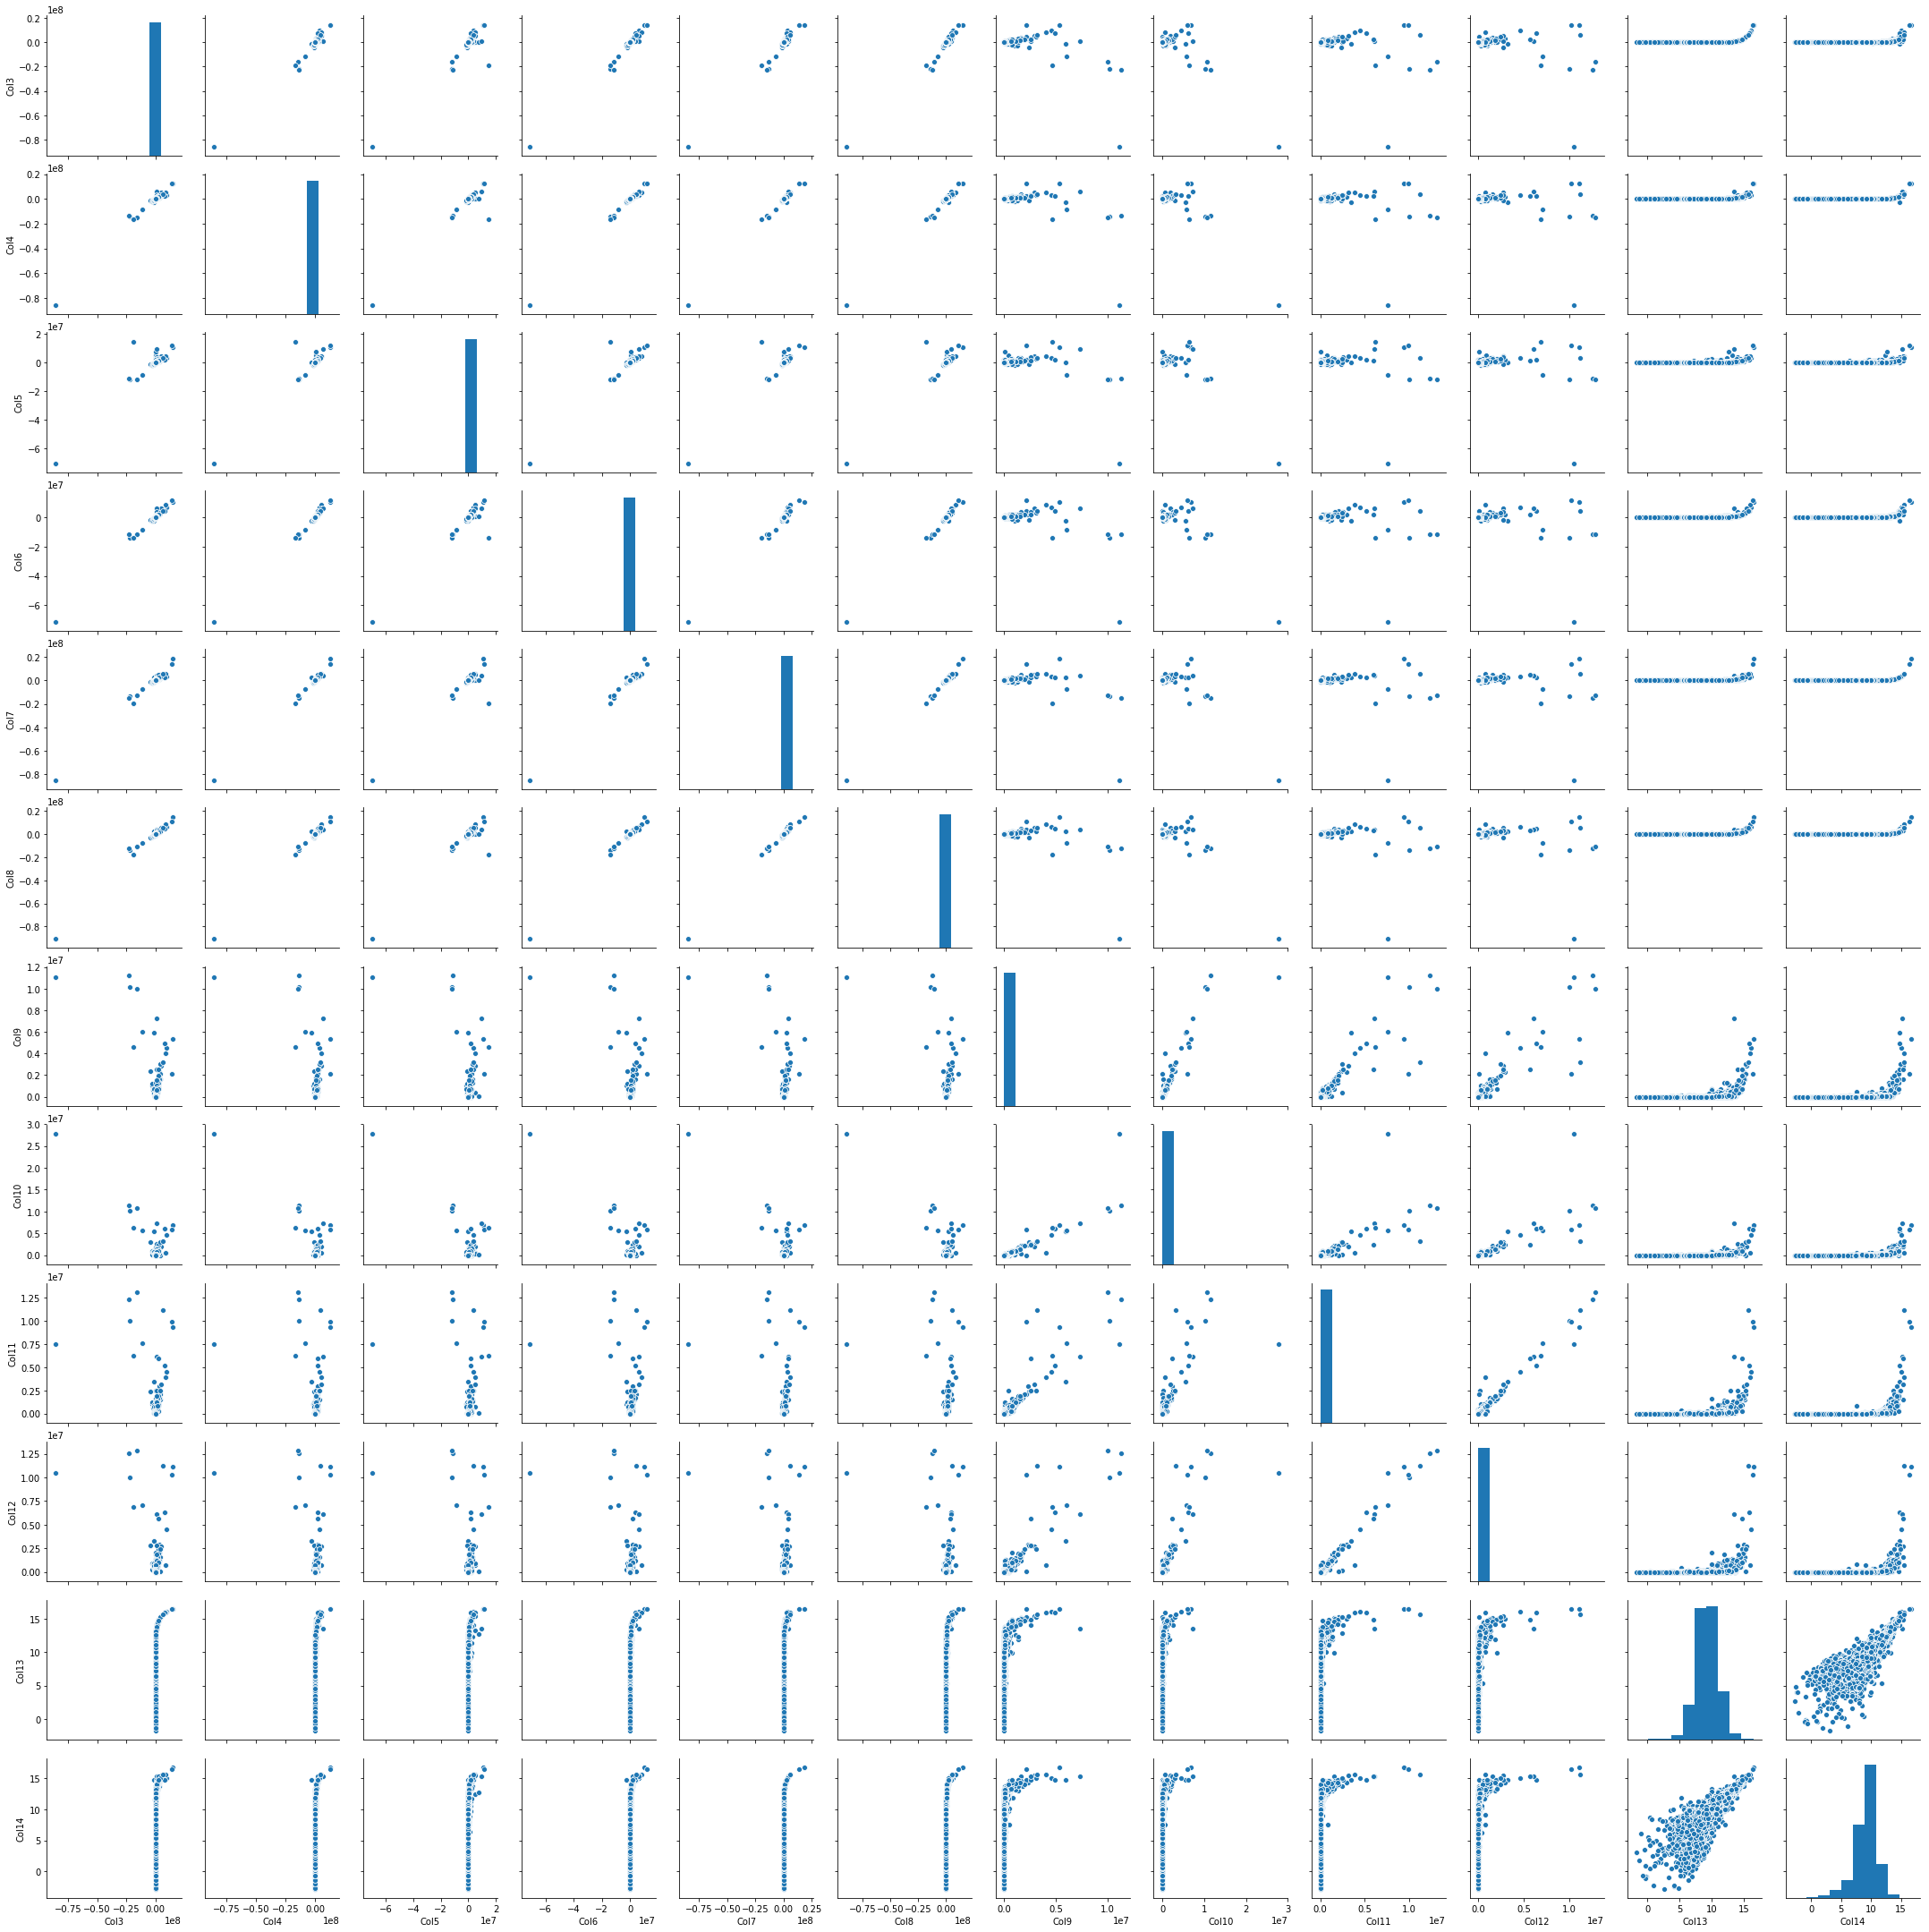

In [42]:
import seaborn as sns

sns.pairplot(df.iloc[:,:12])

In [7]:
reduce_mem_usage_wo_print(df[num_cols])

Memory 104.80 MB ==> 

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 28.64 MB
Decreased by 72.7%


In [9]:
# df.columns

Index(['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9',
       'Col10',
       ...
       'Col2388', 'Col2389', 'Col2390', 'Col2391', 'Col2392', 'Col2393',
       'Col2394', 'Col2395', 'Col2396', 'Col2397'],
      dtype='object', length=2395)

In [8]:
target = df['Col2']
df.drop(['Col1','Col2'], axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(df, target,
                                            test_size=0.3, 
                                            stratify=target, 
                                            random_state=1234)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((12264, 2393), (5257, 2393), (12264,), (5257,))

((17521, 2077), (20442, 2077))

## Drop columns from feature importance of last 2 ensembles

In [11]:
com1 = pd.read_csv('importance.csv')
com2 = pd.read_csv('importance_with_drop_518.csv')
com1.shape, com2.shape

((2393, 4), (1875, 4))

In [16]:
drop_cols1 = com1[com1['sca_imp'] >= 1e-4]['columns'].values
drop_cols2 = com2[com2['sca_imp'] >= 1e-4]['columns'].values
drop_cols1.shape, drop_cols2.shape

((1873,), (1567,))

In [15]:
for i in np.unique(com1['sca_imp']):
    print(i)

0.0
9.259960052192148e-05
9.873124982977458e-05
0.00011769841319364305
0.00013471378491570037
0.00014453766038202467
0.0001633104032860049
0.0001948445126386881
0.000206690941346331
0.00025298209436622454
0.00027387144333888597
0.00029645289504556815
0.0003043227193227988
0.00032245181593688763
0.00032272884571048113
0.00033575788568420534
0.0003573991536816539
0.0003899307769579108
0.0003928758483569799
0.0003950714391869805
0.0003966058904578042
0.00040134481710723776
0.00040394116283359627
0.0004109359790821584
0.000412488692265918
0.00044043418994945457
0.00044242950935109005
0.00046773694251151757
0.00047432464267489055
0.00047853564366125134
0.00048429257256328535
0.0004874921445255046
0.0004968521037913688
0.0005004362626283338
0.0005046488539119026
0.0005078274869608861
0.0005216081544049092
0.0005247228575061403
0.0005270701361848088
0.0005298475902581789
0.0005407377865072664
0.0005517937447353105
0.0005580289820275347
0.0005646721835634588
0.0005843740046011718
0.00060547025

In [19]:
drop_cols = list(set(drop_cols1).union(set(drop_cols2)))
len(drop_cols)

1873

In [20]:
print(X_tr.shape, X_val.shape, "==>> ", end=" ")
X_tr.drop(drop_cols, axis=1, inplace=True)
X_val.drop(drop_cols, axis=1, inplace=True)
print(X_tr.shape, X_val.shape)


(12264, 2393) (5257, 2393) ==>>  (12264, 520) (5257, 520)


/home/ankish/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
tr = X_tr.copy()
val = X_val.copy()
tr['target'] = y_tr
val['target'] = y_val
tr.shape, val.shape

((12264, 521), (5257, 521))

In [22]:
import gc
# del train, valid
# gc.collect()

In [13]:
# tr = X_tr.copy()
# val = X_val.copy()
# tr['target'] = y_tr
# val['target'] = y_val
# tr.shape, val.shape

((12264, 2394), (5257, 2394))

In [23]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpusjffqp6
  JVM stdout: /tmp/tmpusjffqp6/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmpusjffqp6/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 6 months and 16 days !!!"
H2O cluster name:,H2O_from_python_ankish_w5jsu8
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [24]:
# samples = np.random.randint(0,df.shape[0], size=df.shape[0])
# samples = np.random.permutation(samples)
# valid = samples[:5000]
# train = samples[5000:]
# valid.shape, train.shape


train = h2o.H2OFrame(tr)
valid  = h2o.H2OFrame(val)
print(train.shape, valid.shape)


x = X_tr.columns
y = "target"
x = list(x)
# x.remove(y)

del tr, val
gc.collect()

# ignored_columns = ['UniqueID']
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()


/home/ankish/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(12264, 521) (5257, 521)


In [25]:
14*3600

50400

In [26]:
aml = H2OAutoML(max_models=100, seed=1337, max_runtime_secs=50400, nfolds=4)
aml.train(x = x, y = y, training_frame = train, leaderboard_frame = valid)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss
StackedEnsemble_AllModels_0_AutoML_20190921_201225,0.660086,0.310811
StackedEnsemble_BestOfFamily_0_AutoML_20190921_201225,0.656817,0.311097
GBM_grid_0_AutoML_20190921_201225_model_34,0.654375,0.32138
GBM_grid_0_AutoML_20190921_201225_model_20,0.654055,0.319601
GBM_grid_0_AutoML_20190921_201225_model_23,0.654039,0.321924
GBM_grid_0_AutoML_20190921_201225_model_4,0.65395,0.31293
GBM_grid_0_AutoML_20190921_201225_model_7,0.653717,0.311473
GBM_grid_0_AutoML_20190921_201225_model_26,0.652751,0.318271
GBM_grid_0_AutoML_20190921_201225_model_40,0.652647,0.32002
GBM_grid_0_AutoML_20190921_201225_model_9,0.652137,0.322152


In [17]:
lb[:,"model_id"]

model_id
GLM_grid_0_AutoML_20190921_133956_model_0
StackedEnsemble_AllModels_0_AutoML_20190921_133956
StackedEnsemble_BestOfFamily_0_AutoML_20190921_133956
XRT_0_AutoML_20190921_133956
DRF_0_AutoML_20190921_133956
GBM_grid_0_AutoML_20190921_133956_model_0
GBM_grid_0_AutoML_20190921_133956_model_1


In [23]:
m = h2o.get_model(lb[0, "model_id"])

In [1]:
m.std_coef_plot()

NameError: name 'm' is not defined

In [90]:
m__ = h2o.get_model(lb[3, "model_id"])
m__

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_0_AutoML_20190921_133956


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08878717489152668
RMSE: 0.29797176861495905
LogLoss: 0.31572563121775415
Mean Per-Class Error: 0.3865057671519506
AUC: 0.655563085770781
Gini: 0.3111261715415621
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16563385697502966: 


,0,1,Error,Rate
0,7425.0,1406.0,0.1592,(1406.0/8831.0)
1,650.0,346.0,0.6526,(650.0/996.0)
Total,8075.0,1752.0,0.2092,(2056.0/9827.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1656339,0.2518195,203.0
max f2,0.0650465,0.3977330,328.0
max f0point5,0.2779974,0.2424906,118.0
max accuracy,0.5686992,0.8989519,18.0
max precision,0.6466895,0.625,7.0
max recall,0.0252315,1.0,395.0
max specificity,0.8530529,0.9998868,0.0
max absolute_mcc,0.1656339,0.1483763,203.0
max min_per_class_accuracy,0.0956665,0.6066131,284.0
max mean_per_class_accuracy,0.0888340,0.6134942,295.0


Gains/Lift Table: Avg response rate: 10.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100743,0.4491035,3.8867896,3.8867896,0.3939394,0.3939394,0.0391566,0.0391566,288.6789583,288.6789583
,2,0.0200468,0.3806882,2.8189902,3.3556001,0.2857143,0.3401015,0.0281124,0.0672691,181.8990247,235.5600065
,3,0.0300193,0.3396464,2.8189902,3.1773365,0.2857143,0.3220339,0.0281124,0.0953815,181.8990247,217.7336465
,4,0.0400936,0.3090482,2.1925480,2.9298896,0.2222222,0.2969543,0.0220884,0.1174699,119.2547970,192.9889609
,5,0.0500661,0.2870297,2.5169556,2.8476385,0.2551020,0.2886179,0.0251004,0.1425703,151.6955577,184.7638522
,6,0.1000305,0.2185622,1.6879494,2.2683838,0.1710794,0.2299084,0.0843373,0.2269076,68.7949353,126.8383810
,7,0.1499949,0.1803971,1.3865298,1.9746319,0.1405295,0.2001357,0.0692771,0.2961847,38.6529826,97.4631906
,8,0.2000611,0.1539704,1.4639268,1.8468258,0.1483740,0.1871821,0.0732932,0.3694779,46.3926846,84.6825757
,9,0.2999898,0.1159850,1.1152523,1.6031334,0.1130346,0.1624830,0.1114458,0.4809237,11.5252251,60.3133361
,10,0.4000204,0.0978892,1.0438580,1.4632790,0.1057986,0.1483083,0.1044177,0.5853414,4.3858036,46.3278962




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.08469403327686281
RMSE: 0.2910223930849013
LogLoss: 0.3038028931833529
Mean Per-Class Error: 0.3668987341772152
AUC: 0.6628634445723054
Gini: 0.3257268891446108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19304750468581916: 


,0,1,Error,Rate
0,1974.0,226.0,0.1027,(226.0/2200.0)
1,167.0,70.0,0.7046,(167.0/237.0)
Total,2141.0,296.0,0.1613,(393.0/2437.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1930475,0.2626642,134.0
max f2,0.0787731,0.4036067,296.0
max f0point5,0.2310066,0.2557673,100.0
max accuracy,0.6344651,0.9031596,0.0
max precision,0.6344651,1.0,0.0
max recall,0.0357162,1.0,394.0
max specificity,0.6344651,1.0,0.0
max absolute_mcc,0.1930475,0.1747263,134.0
max min_per_class_accuracy,0.1009032,0.5881818,254.0
max mean_per_class_accuracy,0.0970695,0.6331013,261.0


Gains/Lift Table: Avg response rate:  9.73 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102585,0.3699940,4.5243882,4.5243882,0.44,0.44,0.0464135,0.0464135,352.4388186,352.4388186
,2,0.0201067,0.3314270,3.4275668,3.9871696,0.3333333,0.3877551,0.0337553,0.0801688,242.7566807,298.7169551
,3,0.0303652,0.3092025,2.4678481,3.4738853,0.24,0.3378378,0.0253165,0.1054852,146.7848101,247.3885278
,4,0.0402134,0.2883301,1.2853376,2.9379144,0.125,0.2857143,0.0126582,0.1181435,28.5337553,193.7914406
,5,0.0500616,0.2706598,1.2853376,2.6128173,0.125,0.2540984,0.0126582,0.1308017,28.5337553,161.2817320
,6,0.1001231,0.2069959,2.1913952,2.4021062,0.2131148,0.2336066,0.1097046,0.2405063,119.1395172,140.2106246
,7,0.1501847,0.1728354,1.7699730,2.1913952,0.1721311,0.2131148,0.0886076,0.3291139,76.9973023,119.1395172
,8,0.2002462,0.1471176,1.2642664,1.9596130,0.1229508,0.1905738,0.0632911,0.3924051,26.4266445,95.9612990
,9,0.2999590,0.1151853,1.0155754,1.6457947,0.0987654,0.1600547,0.1012658,0.4936709,1.5575350,64.5794732
,10,0.4337300,0.1009053,1.2616810,1.5273264,0.1226994,0.1485336,0.1687764,0.6624473,26.1681033,52.7326364




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.08587127235271136
RMSE: 0.29303800496302757
LogLoss: 0.3052809268588431
Mean Per-Class Error: 0.3616461088380245
AUC: 0.6893117709201658
Gini: 0.37862354184033165
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16316073444134568: 


,0,1,Error,Rate
0,7514.0,1317.0,0.1491,(1317.0/8831.0)
1,597.0,399.0,0.5994,(597.0/996.0)
Total,8111.0,1716.0,0.1948,(1914.0/9827.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1631607,0.2942478,198.0
max f2,0.0879167,0.4140608,299.0
max f0point5,0.2171044,0.2910513,148.0
max accuracy,0.4348612,0.8991554,29.0
max precision,0.6402860,1.0,0.0
max recall,0.0320620,1.0,398.0
max specificity,0.6402860,1.0,0.0
max absolute_mcc,0.2115209,0.2083621,154.0
max min_per_class_accuracy,0.1140837,0.6365462,259.0
max mean_per_class_accuracy,0.1147083,0.6383539,258.0


Gains/Lift Table: Avg response rate: 10.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100743,0.3849163,4.6840798,4.6840798,0.4747475,0.4747475,0.0471888,0.0471888,368.4079753,368.4079753
,2,0.0200468,0.3327895,4.2284854,4.4574389,0.4285714,0.4517766,0.0421687,0.0893574,322.8485370,345.7438893
,3,0.0300193,0.3082499,2.4162774,3.7793581,0.2448980,0.3830508,0.0240964,0.1134538,141.6277354,277.9358110
,4,0.0400936,0.2855003,2.6908543,3.5058508,0.2727273,0.3553299,0.0271084,0.1405622,169.0854326,250.5850814
,5,0.0500661,0.2657408,2.7183120,3.3489833,0.2755102,0.3394309,0.0271084,0.1676707,171.8312024,234.8983332
,6,0.1000305,0.2099245,2.3510723,2.8505354,0.2382892,0.2889115,0.1174699,0.2851406,135.1072314,185.0535407
,7,0.1499949,0.1740129,1.3262459,2.3427836,0.1344196,0.2374491,0.0662651,0.3514056,32.6245921,134.2783618
,8,0.2000611,0.1512413,1.5040344,2.1328830,0.1524390,0.2161750,0.0753012,0.4267068,50.4034430,113.2883007
,9,0.2999898,0.1321408,1.1152523,1.7939029,0.1130346,0.1818182,0.1114458,0.5381526,11.5252251,79.3902884
,10,0.4000204,0.1113312,1.0338209,1.6038341,0.1047813,0.1625541,0.1034137,0.6415663,3.3820940,60.3834059



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.8112375,0.0163296,0.8049451,0.7866300,0.8421374
auc,0.6897679,0.0116384,0.7077286,0.6936100,0.6679650
err,0.1887625,0.0163296,0.1950550,0.2133700,0.1578626
err_count,618.3333,53.54541,639.0,699.0,517.0
f0point5,0.2624174,0.0084472,0.2550261,0.2529566,0.2792696
f1,0.2976217,0.0056135,0.3001095,0.305859,0.2868966
f2,0.3487493,0.0276506,0.3645556,0.3867403,0.2949518
lift_top_group,5.29792,0.7042267,4.9328065,6.6585364,4.3024173
logloss,0.3052823,0.0066803,0.2969645,0.3003863,0.3184959
max_per_class_error,0.6014813,0.0505941,0.5745342,0.5304878,0.6994219


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2019-09-21 13:45:26,1 min 50.418 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-09-21 13:45:28,1 min 51.783 sec,1.0,0.3369629,1.5855568,0.5860916,1.6957988,0.4017832,0.3424944,1.6837186,0.5764269,1.4529903,0.3184243
,2019-09-21 13:45:29,1 min 53.031 sec,2.0,0.3330119,1.4050214,0.5829261,1.8952533,0.3506449,0.3225662,0.5802367,0.5974118,1.3710267,0.2892901
,2019-09-21 13:45:30,1 min 54.401 sec,3.0,0.3341779,1.3698614,0.5742853,2.3847856,0.3106493,0.3130123,0.3944563,0.6117674,1.5233630,0.2892901
,2019-09-21 13:45:35,1 min 58.927 sec,7.0,0.3196145,0.6657213,0.6092798,2.4915318,0.3236391,0.3021271,0.3230689,0.6288186,2.4678481,0.3467378
,2019-09-21 13:45:39,2 min 3.533 sec,11.0,0.3090193,0.4541797,0.6250609,3.4881445,0.2986268,0.2987767,0.3189597,0.6233333,2.4678481,0.4070579
,2019-09-21 13:45:44,2 min 7.894 sec,15.0,0.3028784,0.3409023,0.6467331,3.4881445,0.2519100,0.2956644,0.3127826,0.6378730,3.7017722,0.4144440
,2019-09-21 13:45:48,2 min 12.295 sec,19.0,0.3010492,0.3248074,0.6482075,3.4881445,0.3543660,0.2946850,0.3107707,0.6441427,3.2904641,0.2527698
,2019-09-21 13:45:53,2 min 16.957 sec,23.0,0.2996933,0.3224542,0.6509091,4.0861121,0.3087412,0.2935771,0.3090276,0.6466887,4.5243882,0.2330735
,2019-09-21 13:45:57,2 min 21.660 sec,27.0,0.2989606,0.3178104,0.6518467,3.1891607,0.2130864,0.2922429,0.3062765,0.6545416,4.1130802,0.2064013


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Col141,939.8324585,1.0,0.0501948
Col157,731.3118896,0.7781301,0.0390581
Col770,681.7686768,0.7254151,0.0364121
Col146,632.1630249,0.6726337,0.0337627
Col142,614.7587891,0.6541153,0.0328332
---,---,---,---
Col2381,0.0,0.0,0.0
Col2382,0.0,0.0,0.0
Col2383,0.0,0.0,0.0
Col2385,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [55]:
m1 = h2o.get_model(lb[1, "model_id"])
m2 = h2o.get_model(lb[2, "model_id"])
m3 = h2o.get_model(lb[3, "model_id"])
m4 = h2o.get_model(lb[4, "model_id"])
m5 = h2o.get_model(lb[5, "model_id"])
m6 = h2o.get_model(lb[6, "model_id"])


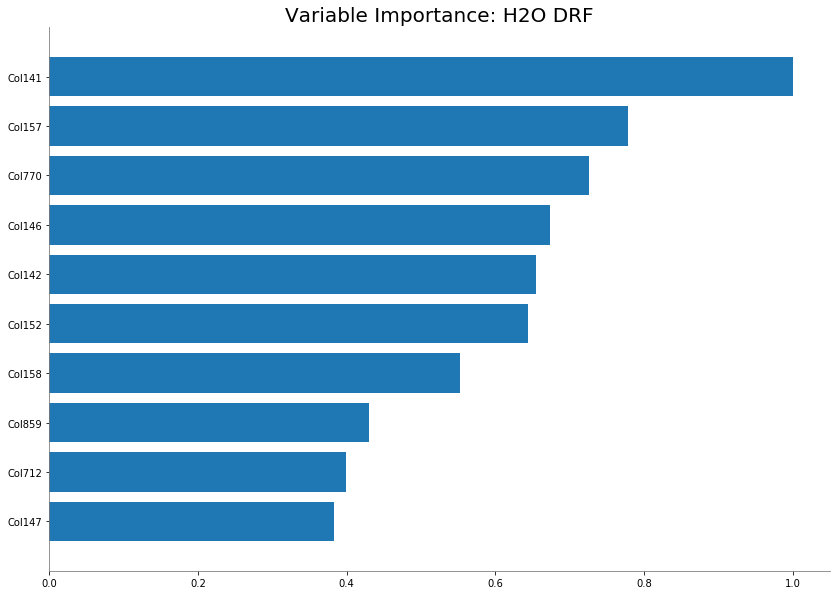

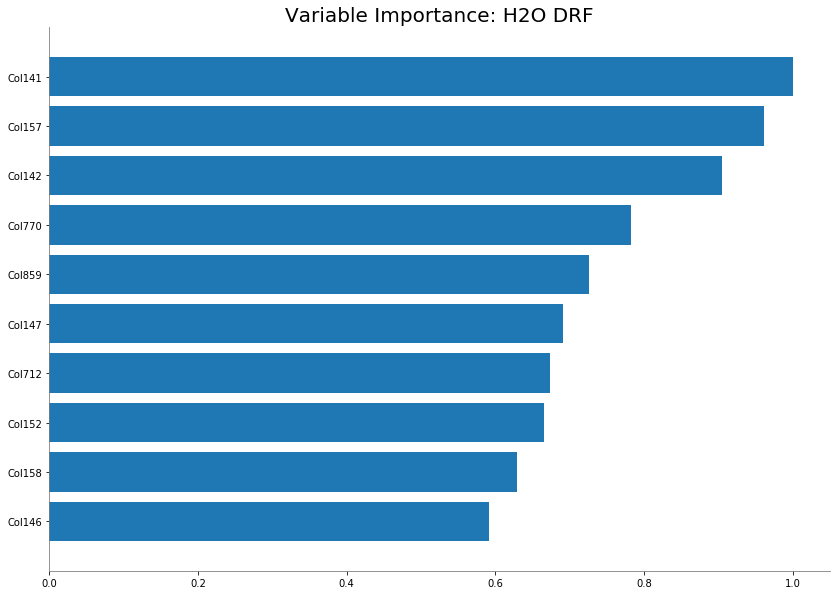

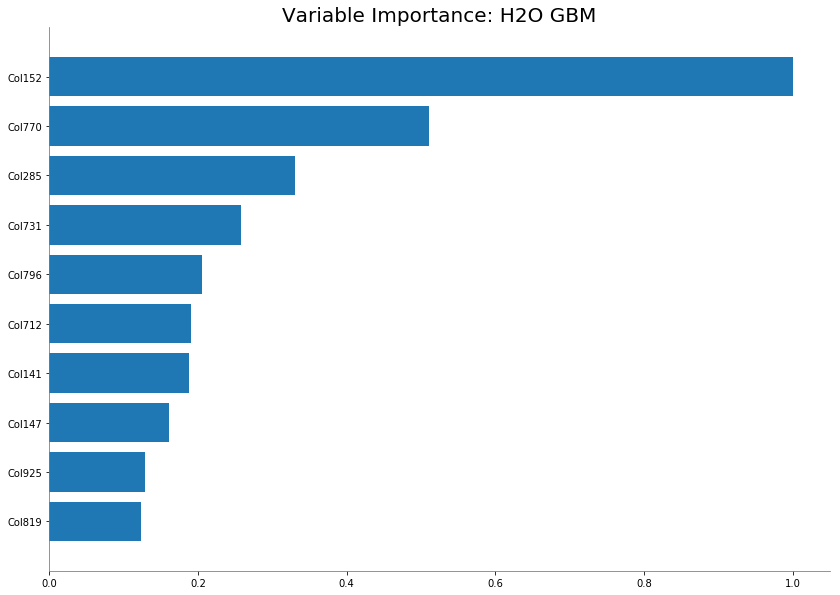

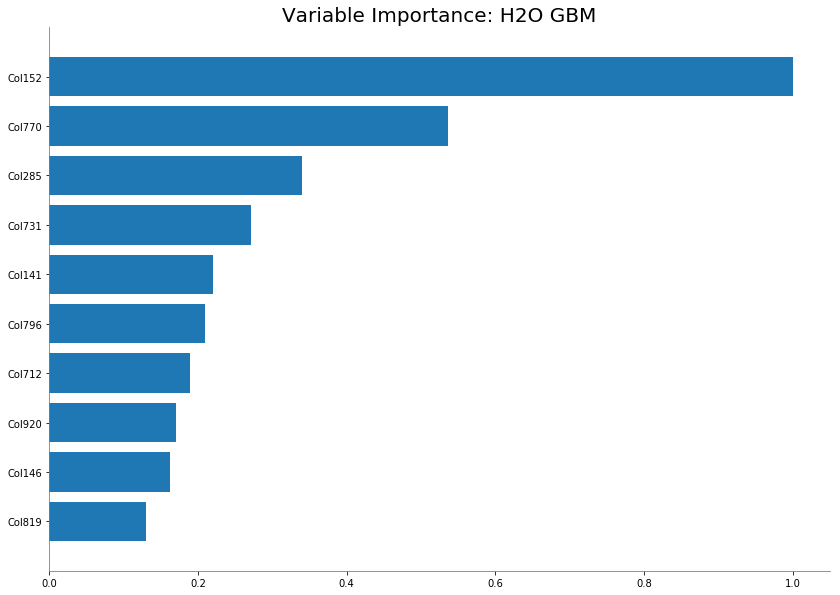

In [67]:
m3.varimp_plot()
m4.varimp_plot()
m5.varimp_plot()
m6.varimp_plot()


In [ ]:
m3.varimp_plot()
m4.varimp_plot()
m5.varimp_plot()
m6.varimp_plot()


In [83]:
# variable 	relative_importance 	scaled_importance 	percentage

m3 = pd.DataFrame(m3.varimp(), columns=['col_name','first','sec','third'])
m4 = pd.DataFrame(m4.varimp(), columns=['col_name','first','sec','third'])
m5 = pd.DataFrame(m5.varimp(), columns=['col_name','first','sec','third'])
m6 = pd.DataFrame(m6.varimp(), columns=['col_name','first','sec','third'])


m3 = m3.sort_values(by='col_name')
m4 = m4.sort_values(by='col_name')
m5 = m5.sort_values(by='col_name')
m6 = m6.sort_values(by='col_name')

combine = pd.DataFrame()

combine['columns'] = m3['col_name']
combine['rel_imp'] = m3['first'] + m4['first'] + m5['first'] + m6['first']
combine['sca_imp'] = m3['sec'] + m4['sec'] + m5['sec'] + m6['sec']
combine['percentage'] = m3['third'] + m4['third'] + m5['third'] + m6['third']

combine

,columns,rel_imp,sca_imp,percentage
1548,Col10,0.882245,0.001569,0.000048
1372,Col100,1.968035,0.002965,0.000107
577,Col1000,7.706653,0.011472,0.000418
1465,Col1001,1.466792,0.002252,0.000080
1738,Col1002,0.666667,0.001186,0.000036
720,Col1003,6.068012,0.009089,0.000329
1739,Col1004,0.666667,0.001186,0.000036
1740,Col1005,0.666667,0.001186,0.000036
1028,Col1006,3.632738,0.005441,0.000197
1741,Col1007,0.666667,0.001186,0.000036


In [95]:
combine.sort_values(by='sca_imp', ascending=False)

,columns,rel_imp,sca_imp,percentage
0,Col141,2482.739746,4.000000,0.492573
1,Col157,1784.627121,2.785223,0.283858
2,Col770,1518.903397,2.299982,0.202071
3,Col146,1331.083359,1.983335,0.166641
4,Col142,1231.580109,1.805627,0.142803
5,Col152,1189.940491,1.735086,0.135963
6,Col158,1082.997391,1.603169,0.126155
7,Col859,941.143074,1.427708,0.110457
8,Col712,872.583519,1.321074,0.099557
9,Col147,816.666000,1.227485,0.089500


In [96]:
combine.sort_values(by='percentage', ascending=False)

,columns,rel_imp,sca_imp,percentage
0,Col141,2482.739746,4.000000,0.492573
1,Col157,1784.627121,2.785223,0.283858
2,Col770,1518.903397,2.299982,0.202071
3,Col146,1331.083359,1.983335,0.166641
4,Col142,1231.580109,1.805627,0.142803
5,Col152,1189.940491,1.735086,0.135963
6,Col158,1082.997391,1.603169,0.126155
7,Col859,941.143074,1.427708,0.110457
8,Col712,872.583519,1.321074,0.099557
9,Col147,816.666000,1.227485,0.089500


In [97]:
combine.sort_values(by='rel_imp', ascending=False)

,columns,rel_imp,sca_imp,percentage
0,Col141,2482.739746,4.000000,0.492573
1,Col157,1784.627121,2.785223,0.283858
2,Col770,1518.903397,2.299982,0.202071
3,Col146,1331.083359,1.983335,0.166641
4,Col142,1231.580109,1.805627,0.142803
5,Col152,1189.940491,1.735086,0.135963
6,Col158,1082.997391,1.603169,0.126155
7,Col859,941.143074,1.427708,0.110457
8,Col712,872.583519,1.321074,0.099557
9,Col147,816.666000,1.227485,0.089500


In [98]:
combine.to_csv('importance.csv', index=None)

In [130]:
drop_cols = combine[combine['sca_imp'] == 0]['columns'].values
drop_cols

array(['Col1338', 'Col1340', 'Col1342', 'Col1343', 'Col1348', 'Col1349',
       'Col1351', 'Col1354', 'Col1355', 'Col1356', 'Col1358', 'Col1362',
       'Col1363', 'Col1366', 'Col1367', 'Col1368', 'Col1375', 'Col1379',
       'Col1380', 'Col1382', 'Col1383', 'Col1384', 'Col1385', 'Col1387',
       'Col1388', 'Col1389', 'Col1391', 'Col1397', 'Col1399', 'Col1400',
       'Col1402', 'Col1403', 'Col1404', 'Col1406', 'Col1407', 'Col1411',
       'Col1414', 'Col1415', 'Col1417', 'Col1419', 'Col1420', 'Col1421',
       'Col1422', 'Col1423', 'Col1428', 'Col1430', 'Col1431', 'Col1432',
       'Col1433', 'Col1436', 'Col1437', 'Col1438', 'Col1439', 'Col1440',
       'Col1442', 'Col1443', 'Col1444', 'Col1446', 'Col1447', 'Col1448',
       'Col1451', 'Col1453', 'Col1456', 'Col1457', 'Col1462', 'Col1468',
       'Col1469', 'Col1472', 'Col1473', 'Col1474', 'Col1478', 'Col1484',
       'Col1487', 'Col1488', 'Col1492', 'Col1493', 'Col1494', 'Col1496',
       'Col1497', 'Col1499', 'Col1500', 'Col1502', 

In [118]:
100/df.shape[1]

0.041788549937317176

In [121]:
# combine[combine['sca_imp'] > 0.01].shape
combine1 = combine.copy()

In [122]:
del train, valid
gc.collect()

1826

In [127]:
tr = X_tr.copy()
val = X_val.copy()
tr['target'] = y_tr
val['target'] = y_val
tr.shape, val.shape

((12264, 2394), (5257, 2394))

In [131]:
print(tr.shape, val.shape, "= => ", end="")
tr.drop(drop_cols, axis=1, inplace=True)
val.drop(drop_cols, axis=1, inplace=True)
print(tr.shape, val.shape)


(12264, 2394) (5257, 2394) = => (12264, 1876) (5257, 1876)


In [143]:
2394 - 1876

518

In [133]:
train = h2o.H2OFrame(tr)
valid  = h2o.H2OFrame(val)
print(train.shape, valid.shape)


x = tr.columns
y = "target"
x = list(x)
x.remove(y)

del tr, val
gc.collect()

# ignored_columns = ['UniqueID']
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()


/home/ankish/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(12264, 1876) (5257, 1876)


In [136]:
aml = H2OAutoML(max_models=5, seed=1337, max_runtime_secs=900, nfolds=3)
aml.train(x = x, y = y, training_frame = train, leaderboard_frame = valid)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss
StackedEnsemble_BestOfFamily_0_AutoML_20190921_143941,0.728468,0.296374
StackedEnsemble_AllModels_0_AutoML_20190921_143941,0.728442,0.296432
GLM_grid_0_AutoML_20190921_143941_model_0,0.726405,0.296283
XRT_0_AutoML_20190921_143941,0.695816,0.302154
DRF_0_AutoML_20190921_143941,0.675075,0.312737
GBM_grid_0_AutoML_20190921_143941_model_0,0.655359,0.326618
GBM_grid_0_AutoML_20190921_143941_model_1,0.641445,0.330101


In [137]:
m3 = h2o.get_model(lb[3, "model_id"])
m4 = h2o.get_model(lb[4, "model_id"])
m5 = h2o.get_model(lb[5, "model_id"])
m6 = h2o.get_model(lb[6, "model_id"])


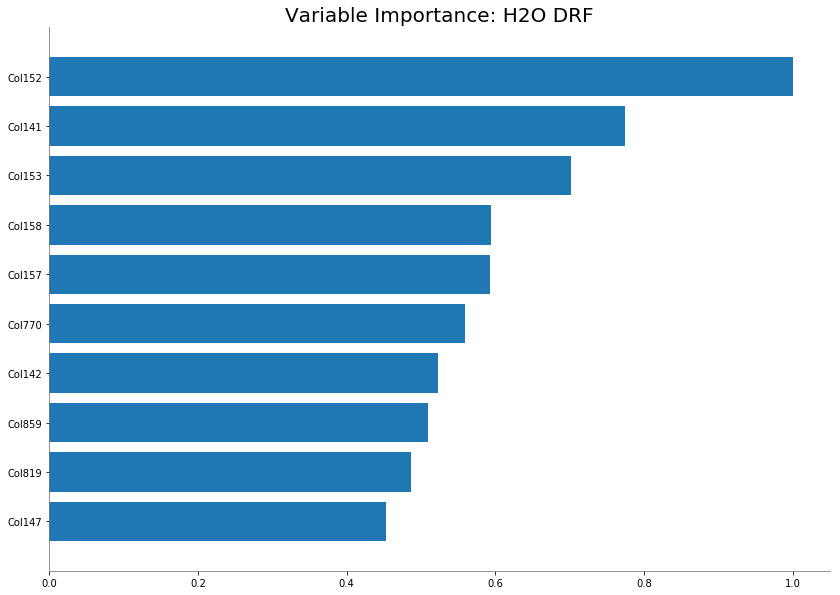

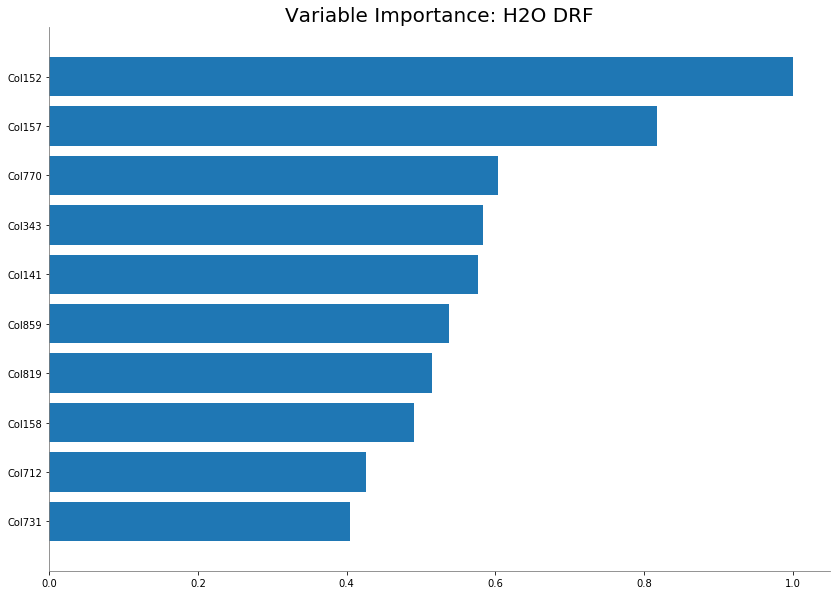

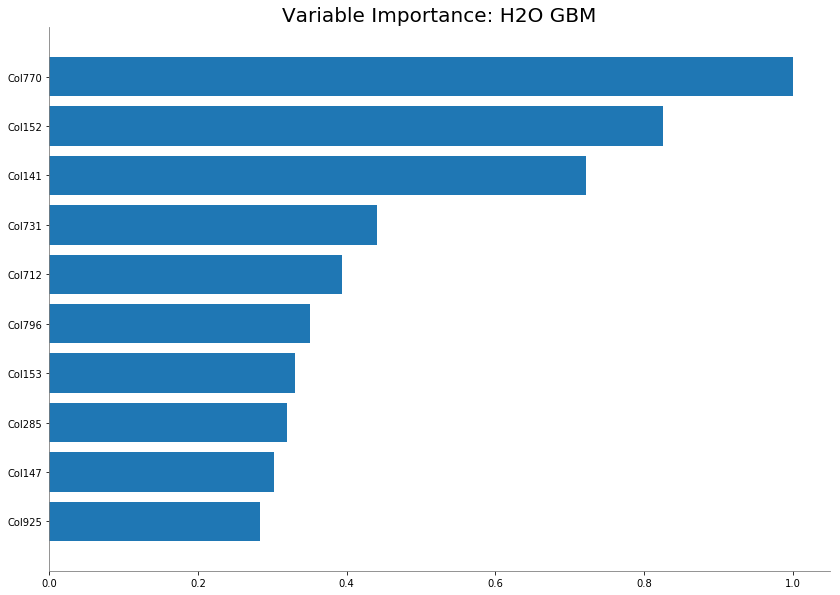

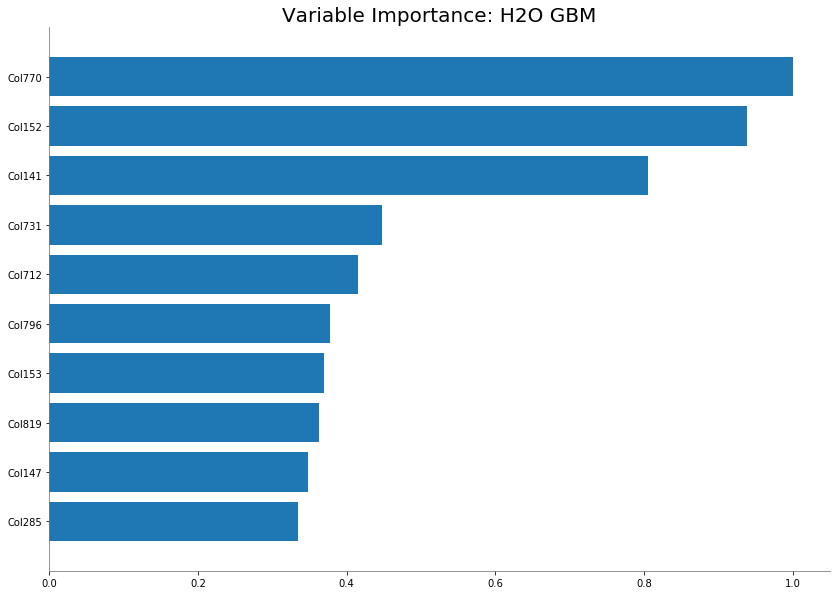

In [139]:
m3.varimp_plot(num_of_features=10)
m4.varimp_plot(num_of_features=10)
m5.varimp_plot(num_of_features=10)
m6.varimp_plot(num_of_features=10)

In [141]:
# variable 	relative_importance 	scaled_importance 	percentage
m3 = pd.DataFrame(m3.varimp(), columns=['col_name','first','sec','third'])
m4 = pd.DataFrame(m4.varimp(), columns=['col_name','first','sec','third'])
m5 = pd.DataFrame(m5.varimp(), columns=['col_name','first','sec','third'])
m6 = pd.DataFrame(m6.varimp(), columns=['col_name','first','sec','third'])


m3 = m3.sort_values(by='col_name')
m4 = m4.sort_values(by='col_name')
m5 = m5.sort_values(by='col_name')
m6 = m6.sort_values(by='col_name')

combine = pd.DataFrame()

combine['columns'] = m3['col_name']
combine['rel_imp'] = m3['first'] + m4['first'] + m5['first'] + m6['first']
combine['sca_imp'] = m3['sec'] + m4['sec'] + m5['sec'] + m6['sec']
combine['percentage'] = m3['third'] + m4['third'] + m5['third'] + m6['third']

combine

,columns,rel_imp,sca_imp,percentage
1412,Col10,0.830149,0.001160,0.000045
227,Col100,19.652648,0.023873,0.001079
1235,Col1000,2.115916,0.002568,0.000105
692,Col1001,6.455554,0.007772,0.000319
1102,Col1002,2.735266,0.003325,0.000136
1568,Col1003,0.056199,0.000079,0.000003
1074,Col1004,2.939765,0.003546,0.000145
1569,Col1005,0.052191,0.000073,0.000003
1010,Col1006,3.409722,0.004107,0.000168
324,Col1007,14.102845,0.016942,0.000711


In [144]:
combine.to_csv('importance_with_drop_518.csv', index=None)

In [147]:
100/df.shape[1]

0.041788549937317176

In [148]:
combine[combine['percentage'] > 0.005]

,columns,rel_imp,sca_imp,percentage
70,Col13,77.398456,0.101917,0.005554
1,Col141,1879.989151,3.353976,0.261753
6,Col142,1116.665253,1.738608,0.121397
36,Col143,340.830748,0.422310,0.022881
10,Col146,908.198166,1.372027,0.094206
9,Col147,940.509521,1.476294,0.104765
20,Col148,564.251526,0.782294,0.047600
54,Col149,126.237144,0.169155,0.009336
0,Col152,2318.377747,4.000000,0.306188
2,Col153,1587.270340,2.831693,0.224225


In [149]:
m1

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_0_AutoML_20190921_133956
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.057800283654152074
RMSE: 0.2404168955255684
LogLoss: 0.21458718678505623
Null degrees of freedom: 9826
Residual degrees of freedom: 9823
Null deviance: 6447.427724852646
Residual deviance: 4217.496569073495
AIC: 4225.496569073495
AUC: 0.9232886136324258
Gini: 0.8465772272648515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2049553500153255: 


,0,1,Error,Rate
0,8574.0,257.0,0.0291,(257.0/8831.0)
1,386.0,610.0,0.3876,(386.0/996.0)
Total,8960.0,867.0,0.0654,(643.0/9827.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2049554,0.6548578,212.0
max f2,0.1325927,0.6843347,263.0
max f0point5,0.2718054,0.7173540,182.0
max accuracy,0.2608405,0.9374173,186.0
max precision,0.9877263,1.0,0.0
max recall,0.0526436,1.0,381.0
max specificity,0.9877263,1.0,0.0
max absolute_mcc,0.2049554,0.6207241,212.0
max min_per_class_accuracy,0.1007948,0.8309365,296.0
max mean_per_class_accuracy,0.1074050,0.8365740,288.0


Gains/Lift Table: Avg response rate: 10.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100743,0.7670398,9.6671433,9.6671433,0.9797980,0.9797980,0.0973896,0.0973896,866.7143321,866.7143321
,2,0.0200468,0.6137575,9.1617183,9.4157136,0.9285714,0.9543147,0.0913655,0.1887550,816.1718302,841.5713616
,3,0.0300193,0.4903496,8.2556143,9.0303247,0.8367347,0.9152542,0.0823293,0.2710843,725.5614294,803.0324689
,4,0.0400936,0.4044441,8.0725630,8.7896688,0.8181818,0.8908629,0.0813253,0.3524096,707.2562979,778.9668828
,5,0.0500661,0.3342446,6.6447627,8.3624314,0.6734694,0.8475610,0.0662651,0.4186747,564.4762724,736.2431433
,6,0.1000305,0.1851820,4.5212929,6.4438160,0.4582485,0.6531027,0.2259036,0.6445783,352.1292911,544.3815956
,7,0.1499949,0.1357591,2.0496528,4.9800886,0.2077393,0.5047490,0.1024096,0.7469880,104.9652786,398.0088604
,8,0.2000611,0.1100752,1.1029586,4.0098201,0.1117886,0.4064090,0.0552209,0.8022088,10.2958582,300.9820053
,9,0.3152539,0.0872736,0.6536969,2.7835026,0.0662544,0.2821175,0.0753012,0.8775100,-34.6303057,178.3502635
,10,0.4000204,0.0820302,0.7935813,2.3618276,0.0804322,0.2393793,0.0672691,0.9447791,-20.6418712,136.1827621




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.08457618313397419
RMSE: 0.29081984652697657
LogLoss: 0.3010139498843911
Null degrees of freedom: 2436
Residual degrees of freedom: 2433
Null deviance: 1555.2611155806387
Residual deviance: 1467.1419917365224
AIC: 1475.1419917365224
AUC: 0.6927608362102032
Gini: 0.38552167242040647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12587993906085176: 


,0,1,Error,Rate
0,1907.0,293.0,0.1332,(293.0/2200.0)
1,148.0,89.0,0.6245,(148.0/237.0)
Total,2055.0,382.0,0.181,(441.0/2437.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1258799,0.2875606,199.0
max f2,0.0651897,0.4146440,331.0
max f0point5,0.2689789,0.2766532,92.0
max accuracy,0.7281464,0.9035700,10.0
max precision,0.9519538,1.0,0.0
max recall,0.0473246,1.0,391.0
max specificity,0.9519538,1.0,0.0
max absolute_mcc,0.1258799,0.1975073,199.0
max min_per_class_accuracy,0.0858246,0.6371308,273.0
max mean_per_class_accuracy,0.0842274,0.6432048,276.0


Gains/Lift Table: Avg response rate:  9.73 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102585,0.5820070,4.1130802,4.1130802,0.4,0.4,0.0421941,0.0421941,311.3080169,311.3080169
,2,0.0201067,0.3994726,4.2844585,4.1970206,0.4166667,0.4081633,0.0421941,0.0843882,328.4458509,319.7020580
,3,0.0303652,0.3526209,1.6452321,3.3349299,0.16,0.3243243,0.0168776,0.1012658,64.5232068,233.4929867
,4,0.0402134,0.3008907,3.8560127,3.4625420,0.375,0.3367347,0.0379747,0.1392405,285.6012658,246.2541979
,5,0.0500616,0.2693796,2.5706751,3.2870928,0.25,0.3196721,0.0253165,0.1645570,157.0675105,228.7092758
,6,0.1001231,0.1645914,1.7699730,2.5285329,0.1721311,0.2459016,0.0886076,0.2531646,76.9973023,152.8532891
,7,0.1501847,0.1290767,2.1913952,2.4161537,0.2131148,0.2349727,0.1097046,0.3628692,119.1395172,141.6153651
,8,0.2002462,0.1088186,1.3485509,2.1492530,0.1311475,0.2090164,0.0675105,0.4303797,34.8550875,114.9252957
,9,0.2999590,0.0881927,0.8886284,1.7301945,0.0864198,0.1682627,0.0886076,0.5189873,-11.1371568,73.0194462
,10,0.4000821,0.0840546,1.3906931,1.6452321,0.1352459,0.16,0.1392405,0.6582278,39.0693090,64.5232068




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08439623432739203
RMSE: 0.2905102998645522
LogLoss: 0.29887634825961273
Null degrees of freedom: 9826
Residual degrees of freedom: 9823
Null deviance: 6450.921665684267
Residual deviance: 5874.1157486944285
AIC: 5882.1157486944285
AUC: 0.7229030491800744
Gini: 0.44580609836014884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15335950667446593: 


,0,1,Error,Rate
0,8032.0,799.0,0.0905,(799.0/8831.0)
1,653.0,343.0,0.6556,(653.0/996.0)
Total,8685.0,1142.0,0.1478,(1452.0/9827.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1533595,0.3208606,220.0
max f2,0.0799847,0.4407241,315.0
max f0point5,0.2453188,0.3398541,156.0
max accuracy,0.6820725,0.8996642,29.0
max precision,0.8307763,0.6666667,14.0
max recall,0.0435716,1.0,396.0
max specificity,0.9517255,0.9998868,0.0
max absolute_mcc,0.1533595,0.2391006,220.0
max min_per_class_accuracy,0.0884430,0.6636847,299.0
max mean_per_class_accuracy,0.0884430,0.6686898,299.0


Gains/Lift Table: Avg response rate: 10.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100743,0.5206568,4.9830636,4.9830636,0.5050505,0.5050505,0.0502008,0.0502008,398.3063567,398.3063567
,2,0.0200468,0.3926045,4.2284854,4.6076896,0.4285714,0.4670051,0.0421687,0.0923695,322.8485370,360.7689642
,3,0.0300193,0.3265095,3.6244160,4.2810428,0.3673469,0.4338983,0.0361446,0.1285141,262.4416031,328.1042815
,4,0.0400936,0.2758890,3.8867896,4.1819792,0.3939394,0.4238579,0.0391566,0.1676707,288.6789583,318.1979186
,5,0.0500661,0.2463667,3.3223814,4.0107585,0.3367347,0.4065041,0.0331325,0.2008032,232.2381362,301.0758481
,6,0.1000305,0.1692983,2.1702206,3.0914257,0.2199593,0.3133266,0.1084337,0.3092369,117.0220597,209.1425723
,7,0.1499949,0.1317457,1.6477601,2.6105303,0.1670061,0.2645862,0.0823293,0.3915663,64.7760083,161.0530317
,8,0.2000611,0.1132612,1.5040344,2.3336249,0.1524390,0.2365209,0.0753012,0.4668675,50.4034430,133.3624937
,9,0.3008039,0.0953810,1.2656981,1.9759634,0.1282828,0.2002706,0.1275100,0.5943775,26.5698146,97.5963393
,10,0.4000204,0.0850842,0.9917063,1.7318396,0.1005128,0.1755279,0.0983936,0.6927711,-0.8293688,73.1839594


In [150]:
h2o.shutdown()

[WARNING] in <ipython-input-150-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_9047 closed.
